# Set up notebook environment for machine learning analysis

In [ ]:
# VERSION SET UP
# need to set some versions
import sys 

# For Google Colab:
# Mounting drive to access datafile
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install imblearn
# !pip install xgboost
# !pip install graphviz

# for Google Workbook:
# !{sys.executable} -m pip install --user pandas==1.3.5
# !{sys.executable} -m pip install --user tensorflow==2.8.2 # 1.15.0 # paper said us 1.10.0, but it doesn't exist???
# !{sys.executable} -m pip install --user numpy==1.21.6 # this one breaks on the tensor to numpy issue: 1.16.0 # tested with 1.16.0 # paper said us 1.15.3, but too many dependency conflicts
# !{sys.executable} -m pip install --user hmmlearn

# for other environments:
# !{sys.executable} -m pip install pandas==1.3.5
# !{sys.executable} -m pip install tensorflow=2.8.2 # 1.15.0 # paper said us 1.10.0, but it doesn't exist???
# !{sys.executable} -m pip install numpy==1.21.6  # this one breaks on the tensor to numpy issue: 1.16.0 # tested with 1.16.0 # paper said us 1.15.3, but too many dependency conflicts
# !{sys.executable} -m pip install hmmlearn

In [44]:
#Importing/installing modules

# Core Libraries for Data Science
import pandas as pd
import numpy as np

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import tree

# pipelines
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config # used to display pipeline diagram

# pre-processing
from sklearn.experimental import enable_halving_search_cv
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, PredefinedSplit, HalvingGridSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# Deep learning
import tensorflow as tf

# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import xgboost as xgb
from ml_models import dummy_classify, run_models, evaluate, evaluate_rr, make_confusion, get_influence
from hmmlearn import hmm

# Evaluation & metrics
from sklearn import metrics
from sklearn.inspection import permutation_importance

# Data Processing
from data_proc import get_split_data, doggo_data_loading # , getXy, oversample, get_default_dataset, get_minority_dataset, get_future_step_dataset

# operations
from collections import Counter
import time
get_ipython().magic('matplotlib inline')
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from pathlib import Path
import shutil

# set up constants
import constants
cat_feats = constants.cat_feats

In [3]:
# version checks
# Python version - should be 3.7.13 or could have issues
print('Python:',sys.version_info, '\n')

pd_check = pd.__version__=='1.3.5'
np_check = np.__version__=='1.21.6'
tf_check = tf.__version__=='2.8.2'
print('Pandas version correct', pd_check)
print('Numpy version correct', np_check)
print('TensorFlow version correct', tf_check)
if(pd_check == True and np_check == True and tf_check == True):
    print("\nVersions all correct")
else:
    print(f"""
    A key version of these libraries is set to the wrong version.
    {pd.__version__}
    {np.__version__}
    {tf.__version__}
    Run the appropriate VERSION SET UP settings above and then restart kernel.
            """)

Python: sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0) 

Pandas version correct True
Numpy version correct True
TensorFlow version correct True

Versions all correct


# Set up Data Approaches

In [4]:
# Set up data for classifiers
# Key variables across model settings
rand_state = 0
test_size = 0.3
seqlen = 1
oversample_strat=1.0
undersample_strat=0.5

start_time = time.time()

# Pull data with training/testing splits
print('default data loading')
X_gs, X_train_def, X_test_def, X_val_def, y_gs, y_train_def, y_test_def, y_val_def, _ = get_split_data(trainsplit=80, seqlen=1, oversample=False, undersample=False, future=False)
print('balanced default data loading')
X_gs_os, X_train_def_os, X_test_def_os, X_val_def_os, y_gs_os, y_train_def_os, y_test_def_os, y_val_def_os, test_fold_def_os = get_split_data(trainsplit=80, seqlen=1, oversample=True, oversample_strat=oversample_strat, undersample=False, undersample_strat=undersample_strat, future=False)
print('future data loading')
X_gs_fs, X_train_fs, X_test_fs, X_val_fs, y_gs_fs, y_train_fs, y_test_fs, y_val_fs, _ = get_split_data(trainsplit=80, seqlen=1, oversample=False, future=True)
print('balanced future data loading')
X_gs_fs_os, X_train_fs_os, X_test_fs_os, X_val_fs_os, y_gs_fs_os, y_train_fs_os, y_test_fs_os, y_val_fs_os, _ = get_split_data(trainsplit=80, seqlen=1, oversample=True, oversample_strat=oversample_strat, undersample=False, undersample_strat=undersample_strat, future=True)

elapsed_time = time.time() - start_time
print(f"Elapsed time to pull up data: {elapsed_time:.3f} seconds")

# make the grid search and optimized model data names a little easier to write
# only using basic data for grid search, since oversampling data results get skewed
X_g, y_g = X_gs_os, y_gs_os  
# Future step:
X_train_fs, X_test_fs, X_val_fs, y_train_fs, y_test_fs, y_val_fs  = X_train_fs_os, X_test_fs_os, X_val_fs_os, y_train_fs_os, y_test_fs_os, y_val_fs_os
# General:
X_train, X_test, X_val, y_train, y_test, y_val  = X_train_def_os, X_test_def_os, X_val_def_os, y_train_def_os, y_test_def_os, y_val_def_os

default data loading
feature size:  42
Joined SIZE:  (73473, 47)
balanced default data loading
feature size:  42
Joined SIZE:  (73473, 47)
Oversampling training set from {0: 54650, 1: 3870} to {0: 54650, 1: 54650}
future data loading
feature size:  42
Joined SIZE:  (73473, 47)
balanced future data loading
feature size:  42
Joined SIZE:  (73473, 47)
Oversampling training set from {0: 51140, 1: 451} to {0: 51140, 1: 51140}
Elapsed time to pull up data: 105.205 seconds


In [5]:
# Local functions and constants for pipelines
def prec_recall_auc(y_test, y_pred):
    # calculate the precision-recall auc
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    auc_score = metrics.auc(recall, precision)
    print('PR AUC: %.3f' % auc_score)
    return auc_score

scorer = metrics.make_scorer(
    prec_recall_auc, # function, taking in y_test, y_pred (which is probabilities based on 'needs_proba' param below
    greater_is_better=True, # this is optimizing for the highest PR AUC score
    needs_proba=True, # the scorer needs proba estimates for the prec_recall curve
    needs_threshold=False # for binary classification that has a predict_proba method
)

half_grid_scoring = metrics.make_scorer(metrics.recall_score) # scorer 
prc_auc_scoring = scorer
ps = PredefinedSplit(test_fold_def_os)

# DUMMY CLASSIFIERS FOR COMPARISON

Using dummy classifiers as benchmarks to compare all models against.

Imbalanced - General Data Pattern
Dummy Classifier results - Strategy:  most_frequent


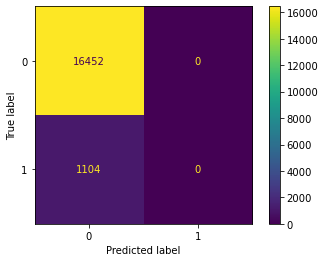

precision:  0.0 
recall:     0.0 
accuracy:   0.9371155160628845 
f1:         0.9066939820199115 

Dummy Classifier results - Strategy:  stratified


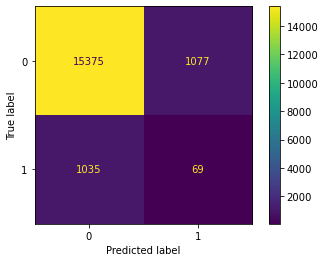

precision:  0.060209424083769635 
recall:     0.0625 
accuracy:   0.8796992481203008 
f1:         0.8807451786303444 

Dummy Classifier results - Strategy:  uniform


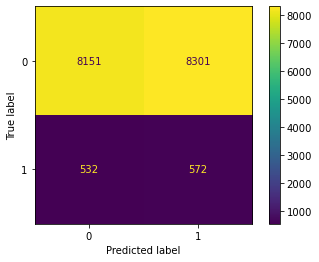

precision:  0.06446523160148766 
recall:     0.5181159420289855 
accuracy:   0.4968671679197995 
f1:         0.6150027770639388 



In [16]:
# Dummy Tests - GENERAL Data Pattern
print('Imbalanced - General Data Pattern')
dummy_classify(X_train_def, y_train_def, test_size=test_size, rand_state=rand_state, avg='weighted')

Balanced - General Data Pattern
Dummy Classifier results - Strategy:  most_frequent


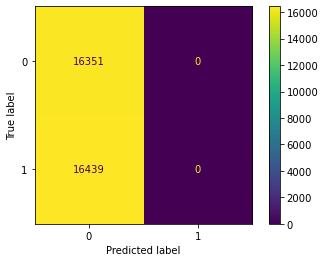

precision:  0.0 
recall:     0.0 
accuracy:   0.4986581274778896 
f1:         0.3318434318549062 

Dummy Classifier results - Strategy:  stratified


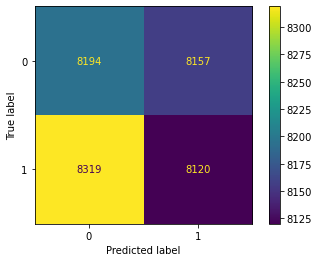

precision:  0.4988634269214229 
recall:     0.4939473203966178 
accuracy:   0.49752973467520584 
f1:         0.49752413224468284 

Dummy Classifier results - Strategy:  uniform


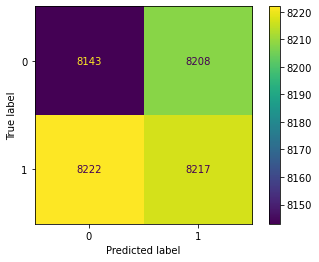

precision:  0.5002739726027398 
recall:     0.49984792262303057 
accuracy:   0.4989326014028667 
f1:         0.49893308421178173 



In [17]:
# Dummy Tests - MINORITY CLASS Data Pattern
print('Balanced - General Data Pattern')
dummy_classify(X_train_def_os, y_train_def_os, test_size=test_size, rand_state=rand_state, avg='weighted')

Imbalanced - Future Stage Data Pattern
Dummy Classifier results - Strategy:  most_frequent


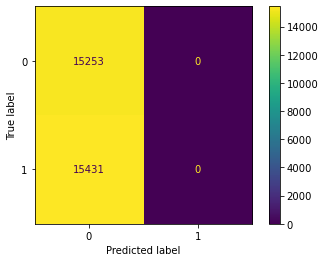

precision:  0.0 
recall:     0.0 
accuracy:   0.49709946551948897 
f1:         0.33011551244394566 

Dummy Classifier results - Strategy:  stratified


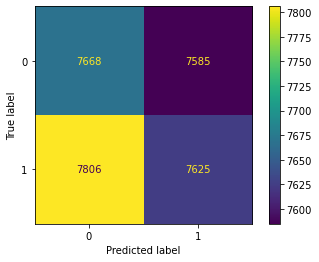

precision:  0.5013149243918474 
recall:     0.49413518242498866 
accuracy:   0.49840307652196586 
f1:         0.49839801370183684 

Dummy Classifier results - Strategy:  uniform


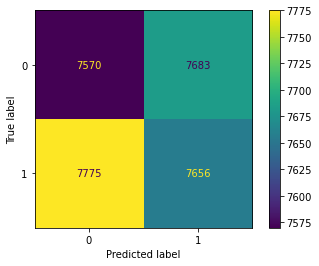

precision:  0.4991198904752591 
recall:     0.49614412546173287 
accuracy:   0.4962195280928171 
f1:         0.4962237616659943 

SMOTENC Balanced - Future Stage Data Pattern
Dummy Classifier results - Strategy:  most_frequent


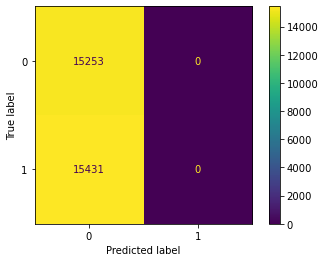

precision:  0.0 
recall:     0.0 
accuracy:   0.49709946551948897 
f1:         0.33011551244394566 

Dummy Classifier results - Strategy:  stratified


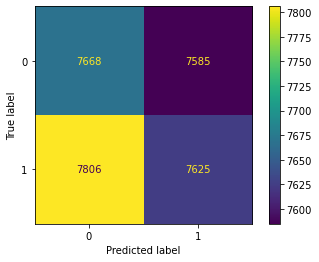

precision:  0.5013149243918474 
recall:     0.49413518242498866 
accuracy:   0.49840307652196586 
f1:         0.49839801370183684 

Dummy Classifier results - Strategy:  uniform


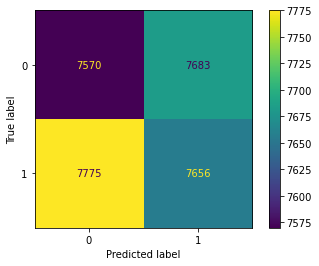

precision:  0.4991198904752591 
recall:     0.49614412546173287 
accuracy:   0.4962195280928171 
f1:         0.4962237616659943 



In [18]:
#Dummy Tests - FUTURE STAGE Data Pattern
# X_precan, y_precan # imbalanced version
# x_nstep, y_nstep # with SMOTENC
print('Imbalanced - Future Stage Data Pattern')
dummy_classify(X_train_fs, y_train_fs, test_size=test_size, rand_state=rand_state, avg='weighted')
print('SMOTENC Balanced - Future Stage Data Pattern')
dummy_classify(X_train_fs_os, y_train_fs_os, test_size=test_size, rand_state=rand_state, avg='weighted')

# Comparing ALL Binary Classification Machine Learning Models

BEGINNING MODEL RUNS
Step 1 of 12: Logistic Regr computation complete - elapsed time: 0.715, model fit time: 0.641 AUC score: 0.5
Step 2 of 12: Ridge Regress computation complete - elapsed time: 0.975, model fit time: 0.175 AUC score: 0.5
Step 3 of 12: StochaGD(SGD) computation complete - elapsed time: 1.769, model fit time: 0.686 AUC score: 0.5
Step 4 of 12: SupVectr(SVC) computation complete - elapsed time: 362.069, model fit time: 347.903 AUC score: 0.548508335402341
Step 5 of 12: LinearKrn-SVC computation complete - elapsed time: 397.518, model fit time: 35.426 AUC score: 0.5
Step 6 of 12: KNeighbor-KNN computation complete - elapsed time: 411.981, model fit time: 0.008 AUC score: 0.7128400219254846
Step 7 of 12: Decision Tree computation complete - elapsed time: 412.990, model fit time: 0.978 AUC score: 0.7679757788164796
Step 8 of 12: Random Forest computation complete - elapsed time: 426.720, model fit time: 13.462 AUC score: 0.7662650992583957
Step 9 of 12: G-Naive Bayes comput

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Train Time
0,Logistic Regr,0.9339,0.0000,0.0000,0.0000,0.5000,0.6
1,Ridge Regress,0.9339,0.0000,0.0000,0.0000,0.5000,0.2
2,StochaGD(SGD),0.9339,0.0000,0.0000,0.0000,0.5000,0.7
3,SupVectr(SVC),0.9388,0.8000,0.0988,0.1758,0.5485,347.9
4,LinearKrn-SVC,0.9339,0.0000,0.0000,0.0000,0.5000,35.4
5,KNeighbor-KNN,0.9422,0.5813,0.4486,0.5064,0.7128,0.0
6,Decision Tree,0.9452,0.5892,0.5638,0.5762,0.7680,1.0
7,Random Forest,0.9491,0.6308,0.5556,0.5908,0.7663,13.5
8,G-Naive Bayes,0.8638,0.1544,0.2366,0.1868,0.5724,0.0
9,B-Naive Bayes,0.9332,0.3529,0.0123,0.0239,0.5054,0.1


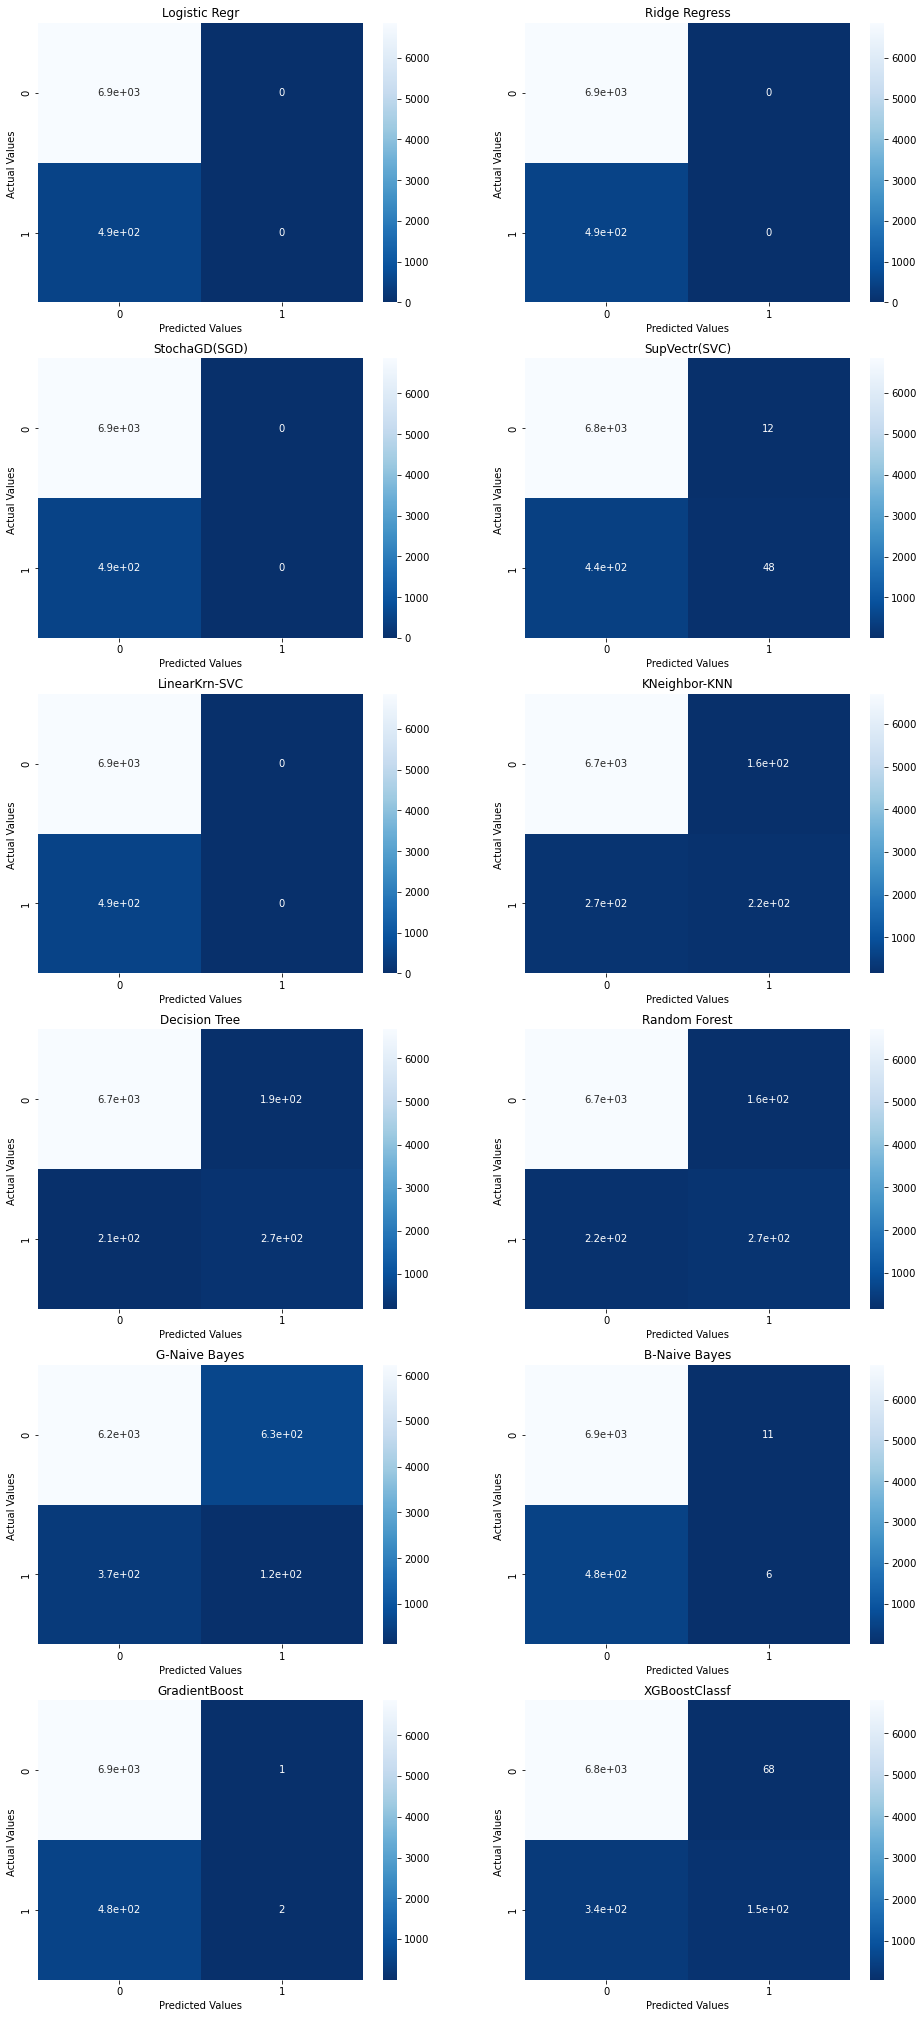

In [6]:
# Model Tests - GENERAL Data Pattern
start_time = time.time()

df = run_models(X_train_def, X_test_def, y_train_def, y_test_def, rand_state=rand_state)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

df 

BEGINNING MODEL RUNS
Step 1 of 12: Logistic Regr computation complete - elapsed time: 1.154, model fit time: 1.099 AUC score: 0.657676078552726
Step 2 of 12: Ridge Regress computation complete - elapsed time: 1.454, model fit time: 0.242 AUC score: 0.6553150109207624
Step 3 of 12: StochaGD(SGD) computation complete - elapsed time: 3.590, model fit time: 2.019 AUC score: 0.6351814669684419
Step 4 of 12: SupVectr(SVC) computation complete - elapsed time: 2017.944, model fit time: 1977.582 AUC score: 0.7388786338072261
Step 5 of 12: LinearKrn-SVC computation complete - elapsed time: 2096.282, model fit time: 78.281 AUC score: 0.6539773524617594
Step 6 of 12: KNeighbor-KNN computation complete - elapsed time: 2119.506, model fit time: 0.036 AUC score: 0.75133855802757
Step 7 of 12: Decision Tree computation complete - elapsed time: 2121.981, model fit time: 2.445 AUC score: 0.7622368312157488
Step 8 of 12: Random Forest computation complete - elapsed time: 2154.305, model fit time: 32.016 

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Train Time
0,Logistic Regr,0.5410,0.1053,0.7922,0.1859,0.6577,1.1
1,Ridge Regress,0.5276,0.1036,0.8025,0.1835,0.6553,0.2
2,StochaGD(SGD),0.5097,0.0978,0.7798,0.1738,0.6352,2.0
3,SupVectr(SVC),0.8658,0.2677,0.5926,0.3688,0.7389,1977.6
4,LinearKrn-SVC,0.5305,0.1035,0.7963,0.1832,0.6540,78.3
5,KNeighbor-KNN,0.8891,0.3182,0.5926,0.4141,0.7513,0.0
6,Decision Tree,0.9309,0.4808,0.5679,0.5208,0.7622,2.4
7,Random Forest,0.9452,0.5842,0.5926,0.5884,0.7814,32.0
8,G-Naive Bayes,0.3915,0.0783,0.7613,0.1420,0.5633,0.1
9,B-Naive Bayes,0.6087,0.1064,0.6646,0.1835,0.6347,0.2


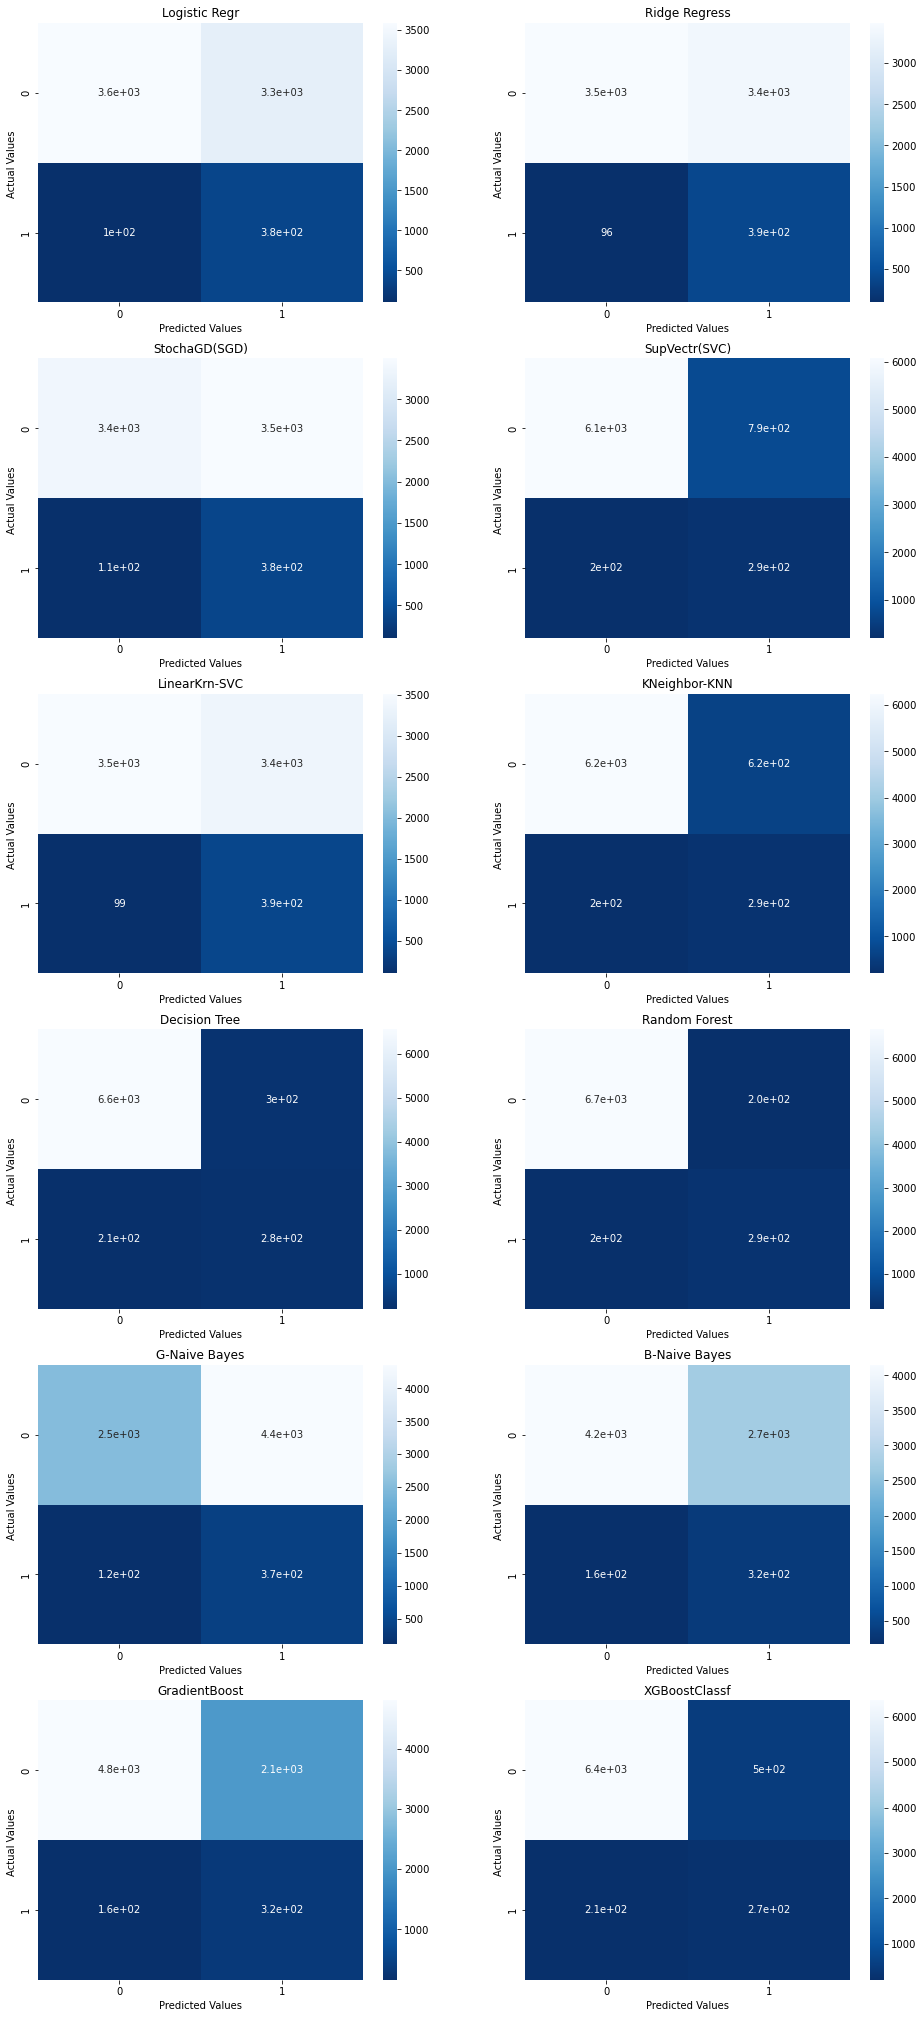

In [7]:
# Model Tests - MINORITY CLASS Oversampled Data Pattern
start_time = time.time()

df = run_models(X_train_def_os, X_test_def_os, y_train_def_os, y_test_def_os, rand_state=rand_state)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

df

Imbalanced - Future Stage Data Pattern
BEGINNING MODEL RUNS
Step 1 of 12: Logistic Regr computation complete - elapsed time: 2.050, model fit time: 1.998 AUC score: 0.5772519993333279
Step 2 of 12: Ridge Regress computation complete - elapsed time: 2.315, model fit time: 0.217 AUC score: 0.5973846780164864
Step 3 of 12: StochaGD(SGD) computation complete - elapsed time: 3.580, model fit time: 1.208 AUC score: 0.5488337336098383
Step 4 of 12: SupVectr(SVC) computation complete - elapsed time: 356.861, model fit time: 342.159 AUC score: 0.5274756350461889
Step 5 of 12: LinearKrn-SVC computation complete - elapsed time: 416.656, model fit time: 59.772 AUC score: 0.5826755410563476
Step 6 of 12: KNeighbor-KNN computation complete - elapsed time: 434.335, model fit time: 0.015 AUC score: 0.6264860094481648
Step 7 of 12: Decision Tree computation complete - elapsed time: 436.748, model fit time: 2.386 AUC score: 0.6447621155364662
Step 8 of 12: Random Forest computation complete - elapsed ti

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Train Time
0,Logistic Regr,0.5584,0.0118,0.5965,0.0232,0.5773,2.0
1,Ridge Regress,0.4776,0.0120,0.7193,0.0237,0.5974,0.2
2,StochaGD(SGD),0.5537,0.0107,0.5439,0.0210,0.5488,1.2
3,SupVectr(SVC),0.8906,0.0134,0.1579,0.0248,0.5275,342.2
4,LinearKrn-SVC,0.5519,0.0120,0.6140,0.0235,0.5827,59.8
5,KNeighbor-KNN,0.9145,0.0355,0.3333,0.0642,0.6265,0.0
6,Decision Tree,0.9852,0.2329,0.2982,0.2615,0.6448,2.4
7,Random Forest,0.9912,0.5000,0.1754,0.2597,0.5869,28.7
8,G-Naive Bayes,0.4569,0.0077,0.4737,0.0151,0.4652,0.1
9,B-Naive Bayes,0.7441,0.0104,0.2982,0.0201,0.5231,0.2


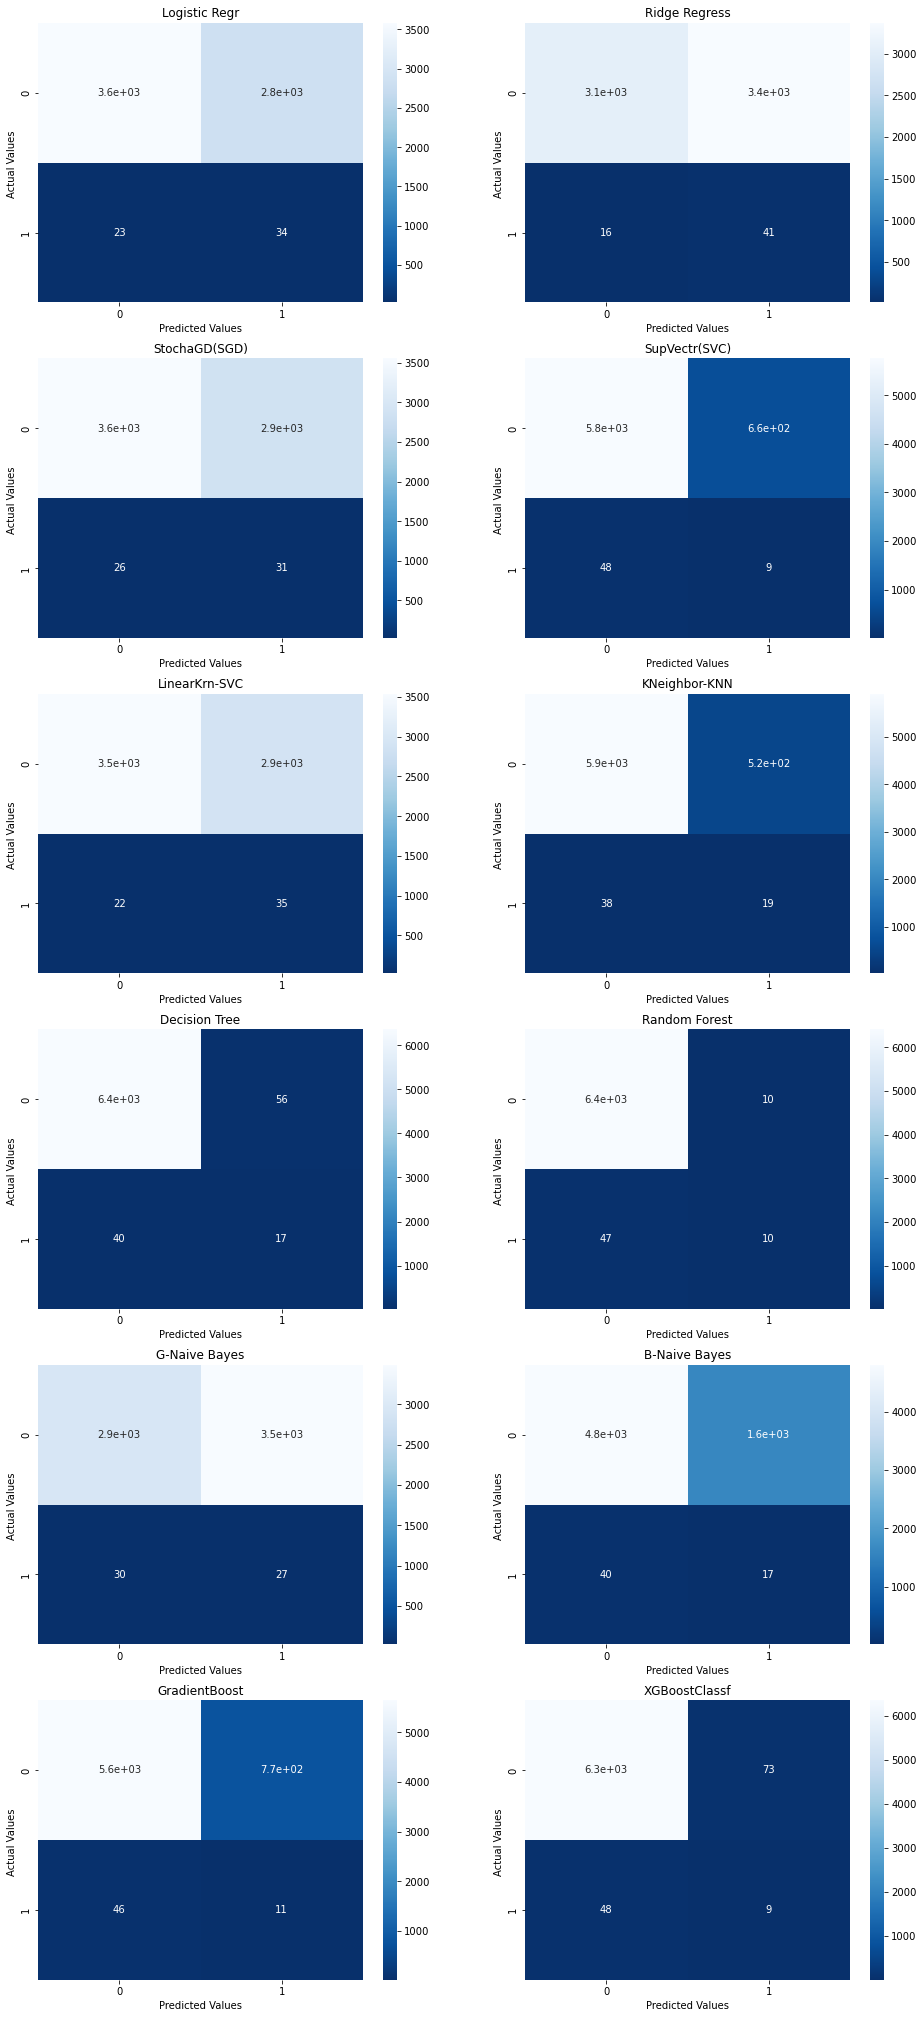

In [8]:
# Model Tests - FUTURE STAGE Data Pattern - Imbalanced
# X_precan, y_precan # imbalanced version
start_time = time.time()

print('Imbalanced - Future Stage Data Pattern')
df = run_models(X_train_fs, X_test_fs, y_train_fs, y_test_fs, rand_state=rand_state)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

df

SMOTENC Balanced - Future Stage Data Pattern
BEGINNING MODEL RUNS
Step 1 of 12: Logistic Regr computation complete - elapsed time: 2.024, model fit time: 1.998 AUC score: 0.5772519993333279
Step 2 of 12: Ridge Regress computation complete - elapsed time: 2.264, model fit time: 0.207 AUC score: 0.5973846780164864
Step 3 of 12: StochaGD(SGD) computation complete - elapsed time: 3.427, model fit time: 1.138 AUC score: 0.5488337336098383
Step 4 of 12: SupVectr(SVC) computation complete - elapsed time: 349.348, model fit time: 335.259 AUC score: 0.5274756350461889
Step 5 of 12: LinearKrn-SVC computation complete - elapsed time: 409.430, model fit time: 60.028 AUC score: 0.5826755410563476
Step 6 of 12: KNeighbor-KNN computation complete - elapsed time: 426.707, model fit time: 0.021 AUC score: 0.6264860094481648
Step 7 of 12: Decision Tree computation complete - elapsed time: 429.075, model fit time: 2.343 AUC score: 0.6447621155364662
Step 8 of 12: Random Forest computation complete - elap

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Train Time
0,Logistic Regr,0.5584,0.0118,0.5965,0.0232,0.5773,2.0
1,Ridge Regress,0.4776,0.0120,0.7193,0.0237,0.5974,0.2
2,StochaGD(SGD),0.5537,0.0107,0.5439,0.0210,0.5488,1.1
3,SupVectr(SVC),0.8906,0.0134,0.1579,0.0248,0.5275,335.3
4,LinearKrn-SVC,0.5519,0.0120,0.6140,0.0235,0.5827,60.0
5,KNeighbor-KNN,0.9145,0.0355,0.3333,0.0642,0.6265,0.0
6,Decision Tree,0.9852,0.2329,0.2982,0.2615,0.6448,2.3
7,Random Forest,0.9912,0.5000,0.1754,0.2597,0.5869,28.1
8,G-Naive Bayes,0.4569,0.0077,0.4737,0.0151,0.4652,0.1
9,B-Naive Bayes,0.7441,0.0104,0.2982,0.0201,0.5231,0.2


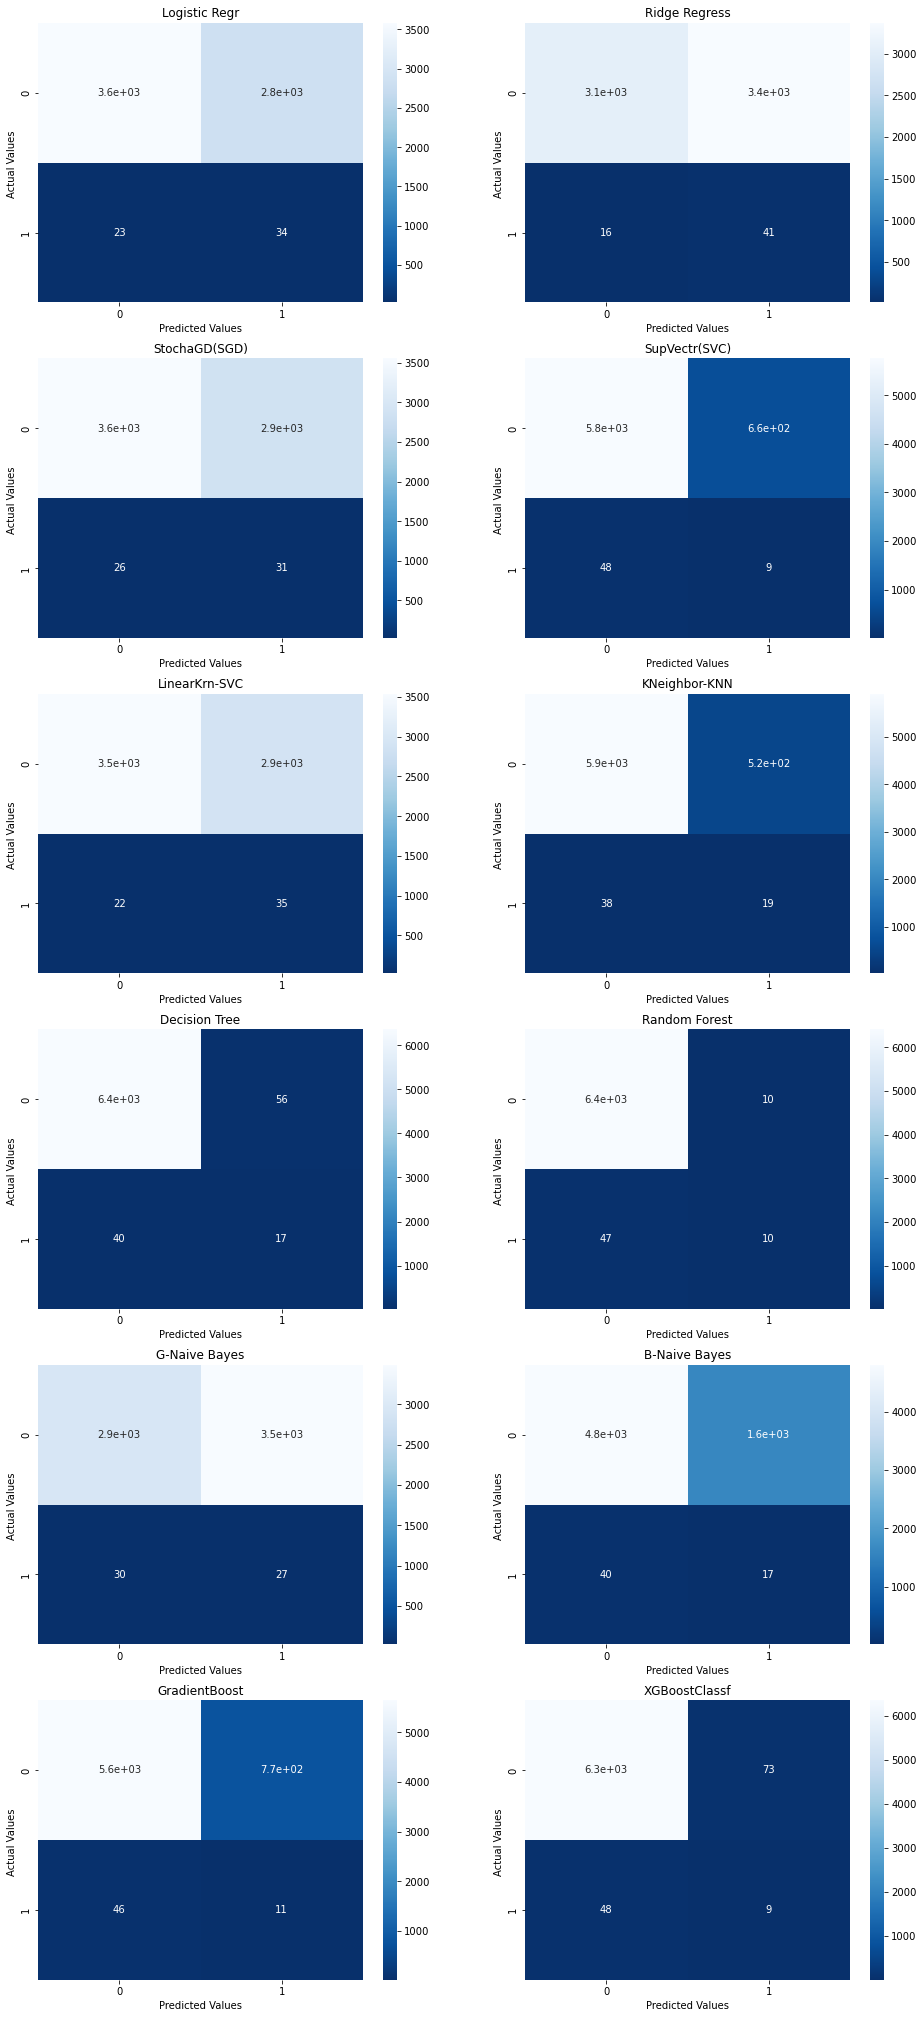

In [9]:
# Model Tests - FUTURE STAGE Data Pattern - Upsampled
# X_nstep, y_nstep # with SMOTENC
start_time = time.time()

print('SMOTENC Balanced - Future Stage Data Pattern')
df = run_models(X_train_fs_os, X_test_fs_os, y_train_fs_os, y_test_fs_os, rand_state=rand_state)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

df

# Model Comparison Results: Focus on Random Forest, Decision Tree, XGBoost, and K Nearest Neighbor, Ridge Regression, SVC

# RANDOM FOREST GRID SEARCHES

In [107]:
# RANDOM FOREST PIPELINE & GRIDSEARCH WITH CROSS VALIDATION - GENERAL DATASET OVERSAMPLED

# ESTIMATORS / STEPS
steps_rf = [
    ("clf", RandomForestClassifier(random_state=rand_state))
]

pipe_rf = Pipeline(steps_rf)

# BEST PARAMS:  {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
# Test score: 0.8436213991769548

grid_params_rf = {
    "clf__n_estimators": [400, 500],
    "clf__max_features": ['sqrt'],
    "clf__max_depth":  [20, 40],
    "clf__criterion": ['entropy'],
    "clf__min_samples_split":  [5],
    'clf__min_samples_leaf': [1,3]
}

# HalvingGridSearchCV
pipe_gs_rf = HalvingGridSearchCV(
                    pipe_rf,
                    grid_params_rf,
                    factor=3, # one 3rd of of candidates are selected
                    scoring=half_grid_scoring,
                    refit=True,
                    verbose=3,
                    random_state=rand_state,
                    n_jobs=1,
                    cv=ps)

set_config(display="diagram")
pipe_gs_rf

HalvingGridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                    estimator=Pipeline(steps=[('clf',
                                               RandomForestClassifier(random_state=0))]),
                    n_jobs=1,
                    param_grid={'clf__criterion': ['entropy'],
                                'clf__max_depth': [20, 40],
                                'clf__max_features': ['sqrt'],
                                'clf__min_samples_leaf': [1, 3],
                                'clf__min_samples_split': [5],
                                'clf__n_estimators': [400, 500]},
                    random_state=0, scoring=make_scorer(recall_score),
                    verbose=3)

In [74]:
# GENERAL DATA

start_time = time.time()

gs_rf = pipe_gs_rf.fit(X_g, y_g)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 38882
max_resources_: 116648
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 38882
Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV 1/1] END clf__criterion=entropy, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=400;, score=(train=0.994, test=0.858) total time=  21.3s
[CV 1/1] END clf__criterion=entropy, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=500;, score=(train=0.994, test=0.856) total time=  26.6s
[CV 1/1] END clf__criterion=entropy, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=3, clf__min_samples_split=5, clf__n_estimators=400;, score=(train=0.986, test=0.846) total time=  20.8s
[CV 1/1] END clf__criterion=entropy, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=3, clf__min_samp

In [76]:
print('BEST SCORE: ', gs_rf.best_score_)
print('BEST PARAMS: ', gs_rf.best_params_)
cv_score = gs_rf.best_score_
test_score = gs_rf.score(X_test_def_os, y_test_def_os)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# BASELINE:  
# 0.6813894667375126
# {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 500}

# BEST SCORE:  0.9130063002996945
# BEST PARAMS:  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
# PR AUC: 0.848
# Cross-validation score: 0.9130063002996945
# Test score: 0.8480386247316007

# RECALL
# BEST SCORE:  0.871244635193133
# BEST PARAMS:  {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
# Cross-validation score: 0.871244635193133
# Test score: 0.8436213991769548

BEST SCORE:  0.8703862660944206
BEST PARAMS:  {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 500}
Cross-validation score: 0.8703862660944206
Test score: 0.8004115226337448


In [77]:
df_cols_rf = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 
           'param_clf__n_estimators',  'param_clf__max_features', 'param_clf__max_depth', 
           'param_clf__criterion', 'param_clf__min_samples_split', 'param_clf__min_samples_leaf',
           'split0_test_score', 'mean_test_score', 'rank_test_score', 'split0_train_score', 'mean_train_score']

#converting the clf.cv_results to dataframe
# gs_rf.cv_results_
df_rf=pd.DataFrame.from_dict(gs_rf.cv_results_)
df_rf[df_cols_rf] # add specific columns to narrow df view

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_estimators,param_clf__max_features,param_clf__max_depth,param_clf__criterion,param_clf__min_samples_split,param_clf__min_samples_leaf,split0_test_score,mean_test_score,rank_test_score,split0_train_score,mean_train_score
0,20.793878,0.0,0.489017,0.0,400,sqrt,20,entropy,5,1,0.857500,0.857500,3,0.994130,0.994130
1,25.995751,0.0,0.606750,0.0,500,sqrt,20,entropy,5,1,0.856250,0.856250,4,0.994299,0.994299
2,20.360415,0.0,0.477371,0.0,400,sqrt,20,entropy,5,3,0.846250,0.846250,6,0.985720,0.985720
3,25.415391,0.0,0.597582,0.0,500,sqrt,20,entropy,5,3,0.845000,0.845000,7,0.985720,0.985720
4,23.379895,0.0,0.525409,0.0,400,sqrt,40,entropy,5,1,0.843750,0.843750,8,0.992832,0.992832
5,29.213917,0.0,0.655772,0.0,500,sqrt,40,entropy,5,1,0.843750,0.843750,8,0.992662,0.992662
6,22.047178,0.0,0.519898,0.0,400,sqrt,40,entropy,5,3,0.836250,0.836250,10,0.984309,0.984309
7,27.301536,0.0,0.643935,0.0,500,sqrt,40,entropy,5,3,0.836250,0.836250,10,0.984422,0.984422
8,74.979974,0.0,1.356420,0.0,400,sqrt,20,entropy,5,3,0.855794,0.855794,5,0.984717,0.984717
9,94.211170,0.0,1.686808,0.0,500,sqrt,20,entropy,5,1,0.870386,0.870386,1,0.989982,0.989982


### RANDOM FOREST GRIDSEARCH RESULTS: FOR RECALL

STARTING:
"clf__n_estimators": [50, 100, 200, 300, 400, 500, 600],\
"clf__max_features":  ['sqrt','log2',None],\
"clf__max_depth":  [None, 20, 40, 60],\
"clf__criterion": ['gini','entropy',],\ # don't use 'log_loss', causes NaN errors
"clf__min_samples_split":  [2,5,8],\
'clf__min_samples_leaf': [1,3]\

##### FINAL:
BEST SCORE:  0.871244635193133\
BEST PARAMS:  \
'clf__criterion': 'entropy', \
'clf__max_depth': 20, \
'clf__max_features': None,\
'clf__min_samples_leaf': 1,\
'clf__min_samples_split': 5,\
'clf__n_estimators': 400\
Cross-validation score: 0.871244635193133\
Test score: 0.8436213991769548

### RANDOM FOREST GRIDSEARCH RESULTS: FOR PRC AUC

STARTING:
"clf__n_estimators": [400, 500, 600],\
"clf__max_features": ['sqrt'],\
"clf__max_depth": [None, 20, 40, 60],\
"clf__criterion": ['gini'],\
"clf__min_samples_split": [2,5,8],\
'clf__min_samples_leaf': [1,3],\

##### ROUND 1:
Ran previous rounds that weren't saved to reduce hyperparameter complexity/processing time.\
Resulted in identifying criterion:'gini', max features:'sqrt'\
Just needed to determine best values for estimators and max depth.\
"clf__n_estimators": [400, 500, 600],\
"clf__max_features": ["sqrt"],\
"clf__max_depth": [None, 20, 40, 60],\
"clf__criterion": ['gini'],\
"clf__min_samples_split": [2,5,8],\
'clf__min_samples_leaf': [1,3],\
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Using oversampled in test:
BEST SCORE:  0.9884853177939871\
BEST PARAMS:  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}\
PR AUC: 0.622\
Cross-validation score: 0.9884853177939871\
Test score: 0.6221658065130029

NOT using oversampled in test:\
BEST SCORE:  0.9127137997499412\
BEST PARAMS:  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}\
PR AUC: 0.850\
Cross-validation score: 0.9127137997499412\
Test score: 0.8497924650744688\
THOUGHTS: keep depth, leaf, splits.  Look lower on estimators.

##### ROUND 2:
"clf__n_estimators": [200, 300, 350],\
BEST SCORE:  0.9125992395474917\
BEST PARAMS:  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}\
PR AUC: 0.849\
Cross-validation score: 0.9125992395474917\
Test score: 0.8492212786187258


##### ROUND 3:
"clf__n_estimators": [100, 200, 400, 450],\
BEST SCORE:  0.9130063002996945\
BEST PARAMS:  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}\
PR AUC: 0.848\
Cross-validation score: 0.9130063002996945\
Test score: 0.8480386247316007

##### ROUND 4:
"clf__n_estimators": [30, 50, 100, 150],\
BEST SCORE:  0.9130063002996945\
BEST PARAMS:  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}\
PR AUC: 0.848\
Cross-validation score: 0.9130063002996945\
Test score: 0.8480386247316007\
THOUGHTS: Max-depth: 100

FINAL:
"clf__n_estimators": [100],\
"clf__max_features": ["sqrt"],\
"clf__max_depth": [None],\
"clf__criterion": ['gini'],\
"clf__min_samples_split": [2],\
'clf__min_samples_leaf': [1]\
BEST SCORE:  0.9130063002996945\
PR AUC: 0.848\
Cross-validation score: 0.9130063002996945\
Test score: 0.8480386247316007


# DECISION TREE GRID SEARCHES

In [80]:
# DECISION TREE PIPELINE & GRIDSEARCH WITH CROSS VALIDATION - GENERAL DATA, OVERSAMPLED

# BEST PARAMS
# PRC-AUC
# 0.8275564179896292
# {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 30}
# PR AUC: 0.633
# Cross-validation score: 0.8275564179896292
# Test score: 0.6326454963405389

# RECALL
# 0.8626609442060086
# {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}
# Cross-validation score: 0.8626609442060086
# Test score: 0.8065843621399177

# ESTIMATORS / STEPS
steps_dt = [
    ("clf", DecisionTreeClassifier(random_state=rand_state))
]

pipe_dt = Pipeline(steps_dt)

grid_params_dt = {
        'clf__criterion': ['entropy'],
        'clf__splitter': ['random'],
        'clf__max_depth': [20, 40],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 5],
        'clf__max_features': [None]
}

pipe_gs_dt = HalvingGridSearchCV(
                    estimator=pipe_dt,
                    param_grid=grid_params_dt,
                    factor=3, # one 3rd of of candidates are selected
                    scoring=half_grid_scoring,
                    refit=True,
                    verbose=3,
                    random_state=rand_state,
                    n_jobs=1,
                    cv=ps)

set_config(display="diagram")
pipe_gs_dt

HalvingGridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                    estimator=Pipeline(steps=[('clf',
                                               DecisionTreeClassifier(random_state=0))]),
                    n_jobs=1,
                    param_grid={'clf__criterion': ['entropy'],
                                'clf__max_depth': [20, 40],
                                'clf__max_features': [None],
                                'clf__min_samples_leaf': [1, 5],
                                'clf__min_samples_split': [2, 5],
                                'clf__splitter': ['random']},
                    random_state=0, scoring=make_scorer(recall_score),
                    verbose=3)

In [81]:
start_time = time.time()

gs_dt = pipe_gs_dt.fit(X_g, y_g)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 38882
max_resources_: 116648
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 38882
Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV 1/1] END clf__criterion=entropy, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__splitter=random;, score=(train=0.987, test=0.840) total time=   0.2s
[CV 1/1] END clf__criterion=entropy, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__splitter=random;, score=(train=0.967, test=0.829) total time=   0.2s
[CV 1/1] END clf__criterion=entropy, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=5, clf__min_samples_split=2, clf__splitter=random;, score=(train=0.952, test=0.825) total time=   0.2s
[CV 1/1] END clf__criterion=entropy, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=5, clf__min_samples

In [82]:
print(gs_dt.best_score_)
print(gs_dt.best_params_)
cv_score = gs_dt.best_score_
test_score = gs_dt.score(X_test_def_os, y_test_def_os)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# BASELINE:
# 0.5495520595577853
# {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 25}

# PRC-AUC
# 0.8275564179896292
# {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 30}
# PR AUC: 0.633
# Cross-validation score: 0.8275564179896292
# Test score: 0.6326454963405389

# RECALL
# 0.8626609442060086
# {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}
# Cross-validation score: 0.8626609442060086
# Test score: 0.8065843621399177


0.8648068669527897
{'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}
Cross-validation score: 0.8648068669527897
Test score: 0.7983539094650206


In [83]:
df_cols_dt = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 
           'param_clf__criterion', 'param_clf__max_depth', 'param_clf__min_samples_split', 'param_clf__min_samples_leaf',
           'param_clf__max_features', 'split0_test_score', 'mean_test_score', 'rank_test_score', 'split0_train_score', 'mean_train_score']

#converting the clf.cv_results to dataframe
df_dt=pd.DataFrame.from_dict(gs_dt.cv_results_)
df_dt[df_cols_dt] # add specific columns to narrow df view

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,split0_test_score,mean_test_score,rank_test_score,split0_train_score,mean_train_score
0,0.225357,0.0,0.006730,0.0,entropy,20,2,1,None,0.840000,0.840000,2,0.987470,0.987470
1,0.222733,0.0,0.006476,0.0,entropy,20,5,1,None,0.828750,0.828750,5,0.966699,0.966699
2,0.215231,0.0,0.006530,0.0,entropy,20,2,5,None,0.825000,0.825000,8,0.952023,0.952023
3,0.211162,0.0,0.006547,0.0,entropy,20,5,5,None,0.825000,0.825000,8,0.952023,0.952023
4,0.232350,0.0,0.006705,0.0,entropy,40,2,1,None,0.836250,0.836250,4,0.992775,0.992775
5,0.242097,0.0,0.006700,0.0,entropy,40,5,1,None,0.828750,0.828750,5,0.981487,0.981487
6,0.230216,0.0,0.006634,0.0,entropy,40,2,5,None,0.816250,0.816250,10,0.952927,0.952927
7,0.239064,0.0,0.007121,0.0,entropy,40,5,5,None,0.816250,0.816250,10,0.952927,0.952927
8,0.913999,0.0,0.014610,0.0,entropy,40,5,1,None,0.827897,0.827897,7,0.983430,0.983430
9,0.937581,0.0,0.014037,0.0,entropy,40,2,1,None,0.839485,0.839485,3,0.987141,0.987141


### DECISION TREE GRIDSEARCH RESULTS:RECALL

STARTING:
"clf__criterion": ['gini','entropy'],\
'clf__splitter": ['best','random']\
"clf__max_depth": [None, 20, 40, 60],\
"clf__min_samples_split": [2, 5, 10, 25, 30, 40, 50, 60],\
'clf__min_samples_leaf': [1, 5, 10],\
"clf__max_features": ['sqrt','log2',None],
    
##### FINAL:
0.8626609442060086\
{'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}\
Cross-validation score: 0.8626609442060086
Test score: 0.8065843621399177


### DECISION TREE GRIDSEARCH RESULTS: PRC AUC

BASELINE FROM PREVIOUS EDA:\
"clf__criterion": ["gini"],\
"clf__max_depth": [None],\
"clf__min_samples_split": [25],\
'clf__min_samples_leaf': [1],\
"clf__max_features": ["sqrt"],

STARTING:\
"clf__criterion": ["gini"],\
"clf__max_depth": [None, 25, 60],\
"clf__min_samples_split": [2, 5, 10, 25, 30],\
'clf__min_samples_leaf': [1, 5, 10],\
"clf__max_features": ["sqrt"],
    
##### ROUND 1:
Fitting 3 folds for each of 45 candidates, totalling 135 fits\
BEFORE TAKING OUT OVERSAMPLED TEST:\
0.9675131039789687\
{'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}\
PR AUC: 0.470\
Cross-validation score: 0.9675131039789687\
Test score: 0.46962295005707155\
DECISIONS: keep depth, samples leaf, go higher on split

##### ROUND 2:
"clf__min_samples_split": [40, 50, 60, 70, 80, 90, 100],\
NOT SAMPLED TEST:\
0.812119501498422\
{'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 40}\
PR AUC: 0.612\
Cross-validation score: 0.812119501498422\
Test score: 0.612054778302288


##### ROUND 3:
"clf__min_samples_split": [30, 35, 40, 45, 50],\
0.8275564179896292\
{'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 30}\
PR AUC: 0.633\
Cross-validation score: 0.8275564179896292\
Test score: 0.6326454963405389


##### FINAL:
"clf__min_samples_split": [20, 25, 30, 35, 40],\
0.8275108158143274\
{'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 35}\
PR AUC: 0.614\
Cross-validation score: 0.8275108158143274\
Test score: 0.61438695105822\
DECISIONS: Use 35

# XGBOOST GRID SEARCHES

In [84]:
# XGBOOST PIPELINE & GRIDSEARCH WITH CROSS VALIDATION - GENERAL DATA, OVERSAMPLED

# PREVIOUS FOR PCA-AUC:
# 'clf__n_estimators': [200, 300, 400, 500, 600],
# 'clf__max_depth': [1, 6, 10, 16, 20, 30, 40, 50, 60, 80, 100],
# 'clf__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
# "clf__nthread": [1, 2, 3, 4, 8, 10]

# PCA-AUC
# 0.5445430774412368
# {'clf__learning_rate': 0.0001, 'clf__max_depth': 1, 'clf__n_estimators': 200, 'clf__nthread': 3}
# PR AUC: 0.460
# Cross-validation score: 0.5445430774412368
# Test score: 0.4601416923044854

# PCA-AUC Using GridSearchSV (rather than HalvingGridSearch):
# 0.5453749886619789
# {'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 150, 'clf__nthread': 1}
# PR AUC: 0.460
# Cross-validation score: 0.5453749886619789
# Test score: 0.4601416923044854

# FOR RECALL:
# 'clf__learning_rate': 0.001, 
# 'clf__max_depth': 1, 
# 'clf__n_estimators': 200, 
# 'clf__nthread': 8

# ESTIMATORS / STEPS
steps_xg = [
    ("clf", xgb.XGBClassifier(objective='binary:logistic', verbosity=0, random_state=rand_state))
]

pipe_xg = Pipeline(steps_xg)

# grid_params_xg = {
#     'clf__n_estimators': [100, 150, 180, 200],
#     'clf__max_depth': [1, None],
#     'clf__learning_rate': [0.001],
#     "clf__nthread": [8]
# }

grid_params_xg = {
    'clf__n_estimators': [150],
    'clf__max_depth': [1],
    'clf__learning_rate': [0.001],
    "clf__nthread": [1]
}


# pipe_gs_xg = HalvingGridSearchCV(
#                         estimator=pipe_xg,
#                         param_grid=grid_params_xg,
#                         factor=3, # one 3rd of of candidates are selected
#                         scoring=prc_auc_scoring, # half_grid_scoring,
#                         refit=True,
#                         verbose=3,
#                         random_state=rand_state,
#                         n_jobs=1,
#                         cv=ps)

pipe_gs_xg = GridSearchCV(
                        estimator=pipe_xg,
                        param_grid=grid_params_xg,
                        # factor=3, # one 3rd of of candidates are selected
                        scoring=prc_auc_scoring, # half_grid_scoring,
                        refit=True,
                        verbose=3,
                        # random_state=rand_state,
                        n_jobs=1,
                        cv=ps)

set_config(display="diagram")
pipe_gs_xg

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=N...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=0,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...))]),
             n_jobs=1,
             param_grid={'clf__learning_rate': [0.001], 'clf__max_depth': [1],
                         'clf__n_estimators': [150], 'clf__nthread': [1]},
             scoring=make_scorer(prec_recall_auc, needs_proba=True), verbose=3)

In [85]:
start_time = time.time()

gs_xg = pipe_gs_xg.fit(X_g, y_g)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Fitting 1 folds for each of 1 candidates, totalling 1 fits
PR AUC: 0.545
[CV 1/1] END clf__learning_rate=0.001, clf__max_depth=1, clf__n_estimators=150, clf__nthread=1;, score=0.545 total time=  11.1s
Elapsed time to compute: 23.728 seconds


In [86]:
print(gs_xg.best_score_)
print(gs_xg.best_params_)
cv_score = gs_xg.best_score_
test_score = gs_xg.score(X_test_def_os, y_test_def_os)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# BASELINE:
# 0.6818395853620597
# {'clf__learning_rate': 0.1, 'clf__max_depth': 16, 'clf__n_estimators': 500, 'clf__nthread': 4}

# PRC AUC - PREVIOUS, BUT RERAN AGAIN, BC RESULTS WERE DIFFERENT
# PR AUC: 0.997
# [CV 1/1] END clf__learning_rate=0.01, clf__max_depth=80, clf__n_estimators=400, clf__nthread=4;,
# score=(train=0.997, test=0.905) total time= 4.0min

# PRC-AUC
# 0.5455258277529701
# {'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 200, 'clf__nthread': 8}
# PR AUC: 0.461
# Cross-validation score: 0.5455258277529701
# Test score: 0.460580420571862

# PRC-AUC with gridsearchSV
# 0.5453749886619789
# {'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 150, 'clf__nthread': 1}
# PR AUC: 0.460
# Cross-validation score: 0.5453749886619789
# Test score: 0.4601416923044854

# RECALL
# 0.844559585492228
# {'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 400, 'clf__nthread': 8}
# Cross-validation score: 0.844559585492228
# Test score: 0.8148148148148148


0.5453749886619789
{'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 150, 'clf__nthread': 1}
PR AUC: 0.460
Cross-validation score: 0.5453749886619789
Test score: 0.4601416923044854


In [87]:
df_cols_xg = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 
           'param_clf__n_estimators', 'param_clf__max_depth', 'param_clf__learning_rate', 'param_clf__nthread',
           'split0_test_score', 'mean_test_score', 'rank_test_score', 'split0_train_score', 'mean_train_score']

#converting the clf.cv_results to dataframe
df_xg=pd.DataFrame.from_dict(gs_xg.cv_results_)
df_xg # [df_cols_xg] # add specific columns to narrow df view

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,param_clf__nthread,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,11.066816,0.0,0.027722,0.0,0.001,1,150,1,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.545375,0.545375,0.0,1


### XGBOOST RESULTS: RECALL

##### START:
'clf__n_estimators': [200, 300, 400, 500, 600],\
'clf__max_depth': [1, 6, 10, 16, 20, 30, 40, 50, 60, 80, 100],\
'clf__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],\
"clf__nthread": [1, 2, 3, 4, 8, 10]


##### FINAL:
0.844559585492228\
'clf__learning_rate': 0.001, \
'clf__max_depth': 1, \
'clf__n_estimators': 400, \
'clf__nthread': 8\
Cross-validation score: 0.844559585492228\
Test score: 0.8148148148148148


### XGBOOST RESULTS: PRC AUC

HAD TO RERUN, WAS GETTING INCONSISENT RESULTS FROM WHAT PREVIOUSLY DETERMINED FOR PRC-AUC

##### ROUND 1:
'clf__n_estimators': [200, 300, 400, 500, 600],\
'clf__max_depth': [1, 6, 10, 16, 20, 30, 40, 50, 60, 80, 100],\
'clf__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],\
"clf__nthread": [1, 2, 3, 4, 8, 10]\
0.5455258277529701\
{'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 200, 'clf__nthread': 8}\
PR AUC: 0.461\
Cross-validation score: 0.5455258277529701\
Test score: 0.460580420571862

##### ROUND 2:
'clf__n_estimators': [100, 150, 180, 200],\
'clf__max_depth': [1, None],\
'clf__learning_rate': [0.001],\
"clf__nthread": [8]\
0.5453754401392402\
{'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 150, 'clf__nthread': 8}\
PR AUC: 0.460\
Cross-validation score: 0.5453754401392402\
Test score: 0.4601416923044854

##### FINAL
'clf__n_estimators': [150],\
'clf__max_depth': [1],\
'clf__learning_rate': [0.001],\
"clf__nthread": [1]


BASELINE FROM PREVIOUS EDA:\
"clf__n_estimators": [500],\
"clf__max_depth": [16],\
'clf__learning_rate': [0.1], # same\
"clf__nthread": [4]


##### ROUND 1:
"clf__n_estimators": [400, 500, 600],\
"clf__max_depth": [1, 6, 10, 16, 20],\
'clf__learning_rate': [0.1, 0.5, 1.0, 2.0],\
"clf__nthread": [4,8,10]\
0.9123488610647398\
{'clf__learning_rate': 0.1, 'clf__max_depth': 20, 'clf__n_estimators': 400, 'clf__nthread': 4}\
PR AUC: 0.892\
Cross-validation score: 0.9123488610647398\
Test score: 0.8915690942399506\
THOUGHTS: < estimmators, < learning rate, > max depth, threads < 4

##### ROUND 2:
"clf__n_estimators": [200, 300, 400],\
"clf__max_depth": [20, 30, 40, 50, 60],\
'clf__learning_rate': [0.01, 0.05, 0.1],\
"clf__nthread": [1, 2, 3, 4]\
0.9047979736493057\
{'clf__learning_rate': 0.01, 'clf__max_depth': 60, 'clf__n_estimators': 400, 'clf__nthread': 4}\
PR AUC: 0.816\
Cross-validation score: 0.9047979736493057\
Test score: 0.8155779289095938\
THOUGHTS: estimators = 400, nthread = 4, max depth >, LR <

##### ROUND 3:
"clf__n_estimators": [400],\
"clf__max_depth": [20, 60, 70, 80, 100],\
'clf__learning_rate': [0.001, 0.005, 0.01, 0.1],\
"clf__nthread": [4]


##### ROUND 4:
PR AUC: 0.905\
PR AUC: 0.997\
[CV 1/1] END clf__learning_rate=0.01, clf__max_depth=80, clf__n_estimators=400, clf__nthread=4;, score=(train=0.997, test=0.905) total time= 4.0min\
THOUGHTS: LR: 0.01, max depth 80 - DONE!

FINAL:\
"clf__n_estimators": [400],\
"clf__max_depth": [80],\
'clf__learning_rate': [0.01],\
"clf__nthread": [4]


PREVIOUS ROUNDS WITH OVERSAMPLED MIXED IN:\
##### ROUND 1:
Fitting 5 folds for each of 81 candidates, totalling 405 fits\
AUC: (test=0.999) Accuracy: (test=0.996) F1: (test=0.996) prec: (test=0.998) recall: (test=0.995) total time=  41.7s\
BEST PARAMS: clf__learning_rate=0.1, clf__max_depth=10, clf__n_estimators=500, clf__nthread=4, verbose=0; \
"clf__n_estimators": [400, 500, 600], # 500\
"clf__max_depth": [1, 10, 20], # 8, 10, 12\
'clf__learning_rate': [0.1, 1.0, 2.0], # same\
"clf__nthread": [4,8,10], # 4\

##### ROUND 2:
Fitting 5 folds for each of 3 candidates, totalling 15 fits\
BEST SCORE: 0.9987512985894311 AUC\
BEST PARAMS: {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 500, 'clf__nthread': 4, 'verbose': 0}\
"clf__n_estimators": [500],\
"clf__max_depth": [10], # TRY NEXT: 8, 10, 12\
'clf__learning_rate': [0.1, 0.5, 1.0], # 0.1\
"clf__nthread": [4],\

##### ROUND 3: Try Max_depth options:
Fitting 5 folds for each of 3 candidates, totalling 15 fits\
BEST SCORE: 0.9988252979213941\
BEST PARAMS: {'clf__learning_rate': 0.1, 'clf__max_depth': 12, 'clf__n_estimators': 500, 'clf__nthread': 4, 'verbose': 0}\
"clf__n_estimators": [500],\
"clf__max_depth": [8, 10, 12], # TRY NEXT: 8, 10, 12\
'clf__learning_rate': [0.1]\
"clf__nthread": [4],\

###### ROUND 4: More Max_depth options
Fitting 5 folds for each of 3 candidates, totalling 15 fits\
Elapsed time to compute: 822.881 seconds\
BEST SCORE: 0.9988518139753964\
BEST PARAMS: {'clf__learning_rate': 0.1, 'clf__max_depth': 14, 'clf__n_estimators': 500, 'clf__nthread': 4, 'verbose': 0}\
"clf__max_depth": [12, 13, 14], # 14

##### ROUND 5: More Max_depth options
Fitting 5 folds for each of 3 candidates, totalling 15 fits\
Elapsed time to compute: 957.647 seconds\
BEST SCORE: 0.9988598093714464\
BEST PARAMS:{'clf__learning_rate': 0.1, 'clf__max_depth': 16, 'clf__n_estimators': 500, 'clf__nthread': 4, 'verbose': 0}\
"clf__max_depth": [15, 16, 17], # 16

# KNN GRID SEARCHES

In [93]:
# KNN PIPELINE & GRIDSEARCH WITH CROSS VALIDATION - GENERAL DATA, OVERSAMPLED

# PRC-AUC BEST PARAMS
# "clf__n_neighbors": [10], # default: 5\
# "clf__weights": ['distance'], # default uniform\
# "clf__algorithm": ['auto'], # default auto\
# "clf__metric": ['minkowski'], # default: minkowski -> so far 'cosine', is leader\
# "clf__n_jobs": [None], # default: None\
# "clf__p": [1]

# RECALL BEST PARAMS
# 0.8648068669527897
# 'clf__algorithm': 'auto', 
# 'clf__metric': 'minkowski', 
# 'clf__n_jobs': 3, 
# 'clf__n_neighbors': 20, 
# 'clf__p': 1, 
# 'clf__weights': 'distance'
# Cross-validation score: 0.8648068669527897
# Test score: 0.05761316872427984

# ESTIMATORS / STEPS
steps_kn = [
    ("clf", KNeighborsClassifier())
]

pipe_kn = Pipeline(steps_kn)

grid_params_kn = {
    "clf__n_neighbors": [20, 30], # default: 5
    "clf__weights": ['distance'], # default uniform
    "clf__algorithm": ['auto'], # default auto
    "clf__metric": ['minkowski'], # default: minkowski -> so far 'cosine', is leader
    "clf__n_jobs": [3, 4], # default: None
    "clf__p": [1, 2]
}

pipe_gs_kn = HalvingGridSearchCV(
                    estimator=pipe_kn,
                    param_grid=grid_params_kn,
                    factor=3, # one 3rd of of candidates are selected
                    scoring=half_grid_scoring,
                    refit=True,
                    verbose=3,
                    random_state=rand_state,
                    n_jobs=1,
                    cv=ps)

set_config(display="diagram")
pipe_gs_kn

HalvingGridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                    estimator=Pipeline(steps=[('clf', KNeighborsClassifier())]),
                    n_jobs=1,
                    param_grid={'clf__algorithm': ['auto'],
                                'clf__metric': ['minkowski'],
                                'clf__n_jobs': [3, 4],
                                'clf__n_neighbors': [20, 30], 'clf__p': [1, 2],
                                'clf__weights': ['distance']},
                    random_state=0, scoring=make_scorer(recall_score),
                    verbose=3)

In [94]:
# Apply Standard Scaler outside of gridsearch to speed it up
sc_X = StandardScaler() 
X_g_ss = sc_X.fit_transform(X_g)
X_g_test_ss = sc_X.fit_transform(X_test_def_os)

In [90]:
start_time = time.time()

gs_kn = pipe_gs_kn.fit(X_g_ss, y_g)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 38882
max_resources_: 116648
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 38882
Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV 1/1] END clf__algorithm=auto, clf__metric=minkowski, clf__n_jobs=3, clf__n_neighbors=20, clf__p=1, clf__weights=distance;, score=(train=0.993, test=0.917) total time=   5.2s
[CV 1/1] END clf__algorithm=auto, clf__metric=minkowski, clf__n_jobs=3, clf__n_neighbors=20, clf__p=2, clf__weights=distance;, score=(train=0.994, test=0.909) total time=   4.3s
[CV 1/1] END clf__algorithm=auto, clf__metric=minkowski, clf__n_jobs=3, clf__n_neighbors=30, clf__p=1, clf__weights=distance;, score=(train=0.993, test=0.919) total time=   5.1s
[CV 1/1] END clf__algorithm=auto, clf__metric=minkowski, clf__n_jobs=3, clf__n_neighbors=30, clf__p=2, clf__weights=distance;, score=(train=0.994, test=0.914) total time=   4.4s
[CV 1/1] END clf__algori

In [91]:
print(gs_kn.best_score_)
print(gs_kn.best_params_)
cv_score = gs_kn.best_score_
test_score = gs_kn.score(X_test_def_os, y_test_def_os)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# BASELINE:
# 0.5458804234489109
# {'clf__algorithm': 'auto', 'clf__metric': 'cosine', 'clf__n_jobs': None, 'clf__n_neighbors': 5, 'clf__weights': 'uniform'}

# 0.8692509390730858
# {'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': None, 'clf__n_neighbors': 10, 'clf__p': 1, 'clf__weights': 'distance'}
# PR AUC: 0.887
# Cross-validation score: 0.8692509390730858
# Test score: 0.8871839443025629

# RECALL
# 0.8648068669527897
# {'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': 3, 'clf__n_neighbors': 20, 'clf__p': 1, 'clf__weights': 'distance'}
# Cross-validation score: 0.8648068669527897
# Test score: 0.05761316872427984

0.8669527896995708
{'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': 3, 'clf__n_neighbors': 30, 'clf__p': 1, 'clf__weights': 'distance'}
Cross-validation score: 0.8669527896995708
Test score: 0.06378600823045268


In [92]:
df_cols_kn = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 
           'param_clf__n_neighbors', 'param_clf__weights', 'param_clf__algorithm', 'param_clf__metric',
           'param_clf__n_jobs', 'param_clf__p',
           'split0_test_score', 'mean_test_score', 'rank_test_score', 'split0_train_score', 'mean_train_score']

#converting the clf.cv_results to dataframe
df_kn=pd.DataFrame.from_dict(gs_kn.cv_results_)
df_kn[df_cols_kn] # add specific columns to narrow df view # df_cols

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_neighbors,param_clf__weights,param_clf__algorithm,param_clf__metric,param_clf__n_jobs,param_clf__p,split0_test_score,mean_test_score,rank_test_score,split0_train_score,mean_train_score
0,0.025547,0.0,5.158618,0.0,20,distance,auto,minkowski,3,1,0.917500,0.917500,3,0.992775,0.992775
1,0.024244,0.0,4.321619,0.0,20,distance,auto,minkowski,3,2,0.908750,0.908750,7,0.994243,0.994243
2,0.022207,0.0,5.118699,0.0,30,distance,auto,minkowski,3,1,0.918750,0.918750,1,0.992775,0.992775
3,0.023337,0.0,4.363128,0.0,30,distance,auto,minkowski,3,2,0.913750,0.913750,5,0.994243,0.994243
4,0.025056,0.0,4.546088,0.0,20,distance,auto,minkowski,4,1,0.917500,0.917500,3,0.992775,0.992775
5,0.026720,0.0,4.252267,0.0,20,distance,auto,minkowski,4,2,0.908750,0.908750,7,0.994243,0.994243
6,0.021541,0.0,4.524476,0.0,30,distance,auto,minkowski,4,1,0.918750,0.918750,1,0.992775,0.992775
7,0.024460,0.0,4.163199,0.0,30,distance,auto,minkowski,4,2,0.913750,0.913750,5,0.994243,0.994243
8,0.069543,0.0,46.006034,0.0,20,distance,auto,minkowski,4,1,0.864807,0.864807,11,0.987122,0.987122
9,0.063427,0.0,49.992710,0.0,30,distance,auto,minkowski,3,1,0.866953,0.866953,9,0.987122,0.987122


### KNN RESULTS: RECALL

"clf__n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30], # default: 5\
"clf__weights": ['uniform','distance'], # default uniform\
"clf__algorithm": ['auto'], # default auto\
"clf__metric": ['cosine','euclidean','l2','minkowski'], # default: minkowski -> so far 'cosine', is leader\
"clf__n_jobs": [None, 2, 3, 4, 8], # default: None\
"clf__p": [1, 2]


##### ROUND 1:
0.8618025751072962\
{'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': 3, 'clf__n_neighbors': 30, 'clf__p': 1, 'clf__weights': 'distance'}\
Cross-validation score: 0.8618025751072962\
Test score: 0.7860082304526749


##### FINAL:
0.8648068669527897\
{'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': 3, 'clf__n_neighbors': 20, 'clf__p': 1, 'clf__weights': 'distance'}\
Cross-validation score: 0.8648068669527897\
Test score: 0.05761316872427984


### KNN RESULTS: PRC AUC

BASELINE FROM PREVIOUS EDA:\
"clf__n_neighbors": [5], # default: 5\
"clf__weights": ['uniform'], # ['uniform','distance'], # default uniform\
"clf__algorithm": ['auto'], # ['auto','ball_tree','kd_tree','brute'], # default auto\
"clf__metric": ['cosine'], # default: minkowski -> so far 'cosine', is leader\
"clf__n_jobs": [None] # [1,2,3] # default: None
    
##### ROUND 1:
"clf__n_neighbors": [4, 5, 6], # default: 5\
"clf__weights": ['uniform','distance'], # default uniform\
"clf__algorithm": ['auto'], # default auto\
"clf__metric": ['cosine','euclidean','l2','minkowski'], # default: minkowski -> so far 'cosine', is leader\
"clf__n_jobs": [None, 2], # default: None\
"clf__p": [1,2], \
0.8642829096540104\
{'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': None, 'clf__n_neighbors': 6, 'clf__p': 1, 'clf__weights': 'distance'}\
PR AUC: 0.882\
Cross-validation score: 0.8642829096540104\
Test score: 0.882321327468085\
DECISIONS: metric: minkowsi (default), n_jobs = None, neighbors 6+, p = 1, weights: distance

##### ROUND 2:
"clf__n_neighbors": [6, 7, 8, 10, 15],\
neighbors 6+\
0.8692509390730858\
{'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': None, 'clf__n_neighbors': 10, 'clf__p': 1, 'clf__weights': 'distance'}\
PR AUC: 0.887\
Cross-validation score: 0.8692509390730858\
Test score: 0.8871839443025629\
DECISIONS: Select 10 for neighbors

FINAL PARAMS:\
"clf__n_neighbors": [10], # default: 5\
"clf__weights": ['distance'], # default uniform\
"clf__algorithm": ['auto'], # default auto\
"clf__metric": ['minkowski'], # default: minkowski -> so far 'cosine', is leader\
"clf__n_jobs": [None], # default: None\
"clf__p": [1]


# PREVIOUS EDA:
##### ROUND 1: Look for any standouts in the metric category (everything else set to default:
"clf__metric": ['cosine','euclidean','l2','minkowski']\
Fitting 3 folds for each of 4 candidates, totalling 12 fits\
"clf__n_neighbors": [5], # [1,2,4,5], # default: 5\
"clf__weights": ['uniform'], # ['uniform','distance'], # default uniform\
"clf__algorithm": ['auto'], # ['auto','ball_tree','kd_tree','brute'], # default auto\
'clf__leaf_size': [30], # [20,30,40], # default 30, only matters if using ball_tree or kd_tree\
"clf__p": [1,2], # default 2, only matters if using minkowski\
"clf__metric": ['minkowski'], # default: minkowski -> so far 'cosine', is leader\
"clf__n_jobs": [None] # [1,2,3] # default: None\
NOTE: Had all the other metric options, but most of them failed or were 20X longer to run\
0.5458804234489109\
DECISIONS: Select cosine

##### ROUND 2: Try 2 options with minkowski (see if it can be better than cosine by itself)
Fitting 3 folds for each of 2 candidates, totalling 6 fits\
0.5392818338321809\
{'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'minkowski', 'clf__n_jobs': None, 'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'uniform'}\
DECISIONS: cosine is still faster than either of these options

##### ROUND 3: testing algorithm 'auto','ball_tree','kd_tree','brute'
"clf__algorithm": ['auto','ball_tree','kd_tree','brute'], \
Fitting 3 folds for each of 4 candidates, totalling 12 fits\
0.5458804234489109\
{'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'cosine', 'clf__n_jobs': None, 'clf__n_neighbors': 5, 'clf__weights': 'uniform'}\
NOTE: the tree algos don't work with cosine, other 2 were equal\
DECISIONS: use auto, since it was the same across the two that worked

###### ROUND 4: Neighbors and distance
"clf__n_neighbors": [1, 3, 5], # [1,2,4,5], # default: 5\
"clf__weights": ['uniform','distance'], # ['uniform','distance'], # default uniform\
Fitting 3 folds for each of 6 candidates, totalling 18 fits\
0.5458804234489109\
{'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'cosine', 'clf__n_jobs': None, 'clf__n_neighbors': 5, 'clf__weights': 'uniform'}\
DECISIONS: Use uniform, explore neighbors more

##### ROUND 5: More neighbors
"clf__n_neighbors": [7,9,11]\
Fitting 3 folds for each of 3 candidates, totalling 9 fits\
0.5650368264208606\
{'clf__algorithm': 'auto', 'clf__metric': 'cosine', 'clf__n_jobs': None, 'clf__n_neighbors': 11, 'clf__weights': 'uniform'}\
DECISIONS: Clear improvements with more neighbors, keep pushing

##### ROUND 6:
"clf__n_neighbors": [15,20,30],\
Fitting 3 folds for each of 3 candidates, totalling 9 fits\
0.60229980951943\
{'clf__algorithm': 'auto', 'clf__metric': 'cosine', 'clf__n_jobs': None, 'clf__n_neighbors': 30, 'clf__weights': 'uniform'}\

##### ROUND 7:
"clf__n_neighbors": [45,60,75],
Fitting 3 folds for each of 3 candidates, totalling 9 fits\
0.6392021309446136\
{'clf__algorithm': 'auto', 'clf__metric': 'cosine', 'clf__n_jobs': None, 'clf__n_neighbors': 75, 'clf__weights': 'uniform'}\
DECISIONS: AUC going up, but F1/recall/precision going wrong way. 

##### ROUND 8: Rerun neighbors with other metrics:

Fitting 3 folds for each of 8 candidates, totalling 24 fits\
"clf__n_neighbors": [3, 5, 7,9,11,15,20,30]\
0.60229980951943\
{'clf__algorithm': 'auto', 'clf__metric': 'cosine', 'clf__n_jobs': None, 'clf__n_neighbors': 30, 'clf__weights': 'uniform'}\
DECISIONS: Anything over 5 neighbors and F1 starts going down, and it is already dismal, use 5

##### FINAL: N_jobs
"clf__n_jobs": [None, 2, 3]\
Fitting 3 folds for each of 3 candidates, totalling 9 fits\
Doesn't make a difference, just makes it take longer\
final hyperparams:\
"clf__n_neighbors": [5], # default: 5\
"clf__weights": ['uniform'],# default uniform\
"clf__algorithm": ['auto'], # default auto\
"clf__metric": ['cosine'], # default: minkowski -> so far 'cosine', is leader\
"clf__n_jobs": [None]

# RIDGE REGRESSION GRID SEARCHES

In [95]:
# Local functions specific to ridge regression

def prec_recall_auc_rr(y_test, y_pred):
    # calculate the precision-recall auc
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    auc_score = metrics.auc(recall, precision)
    print('PR AUC: %.3f' % auc_score)
    return auc_score

scorer_rr = metrics.make_scorer(
    prec_recall_auc_rr, # function, taking in y_test, y_pred (which is probabilities based on 'needs_proba' param below
    greater_is_better=True, # this is optimizing for the highest PR AUC score
    needs_proba=False, # the scorer needs proba estimates for the prec_recall curve
    needs_threshold=True # for binary classification that has a predict_proba method
)

prc_auc_scoring_rr = scorer_rr

In [98]:
# RR PIPELINE & GRIDSEARCH WITH CROSS VALIDATION - GENERAL DATA, OVERSAMPLED

# PRC-AUC BEST PARAM
# 0.3134638633694533
# {'clf__alpha': 8, 'clf__fit_intercept': False, 'clf__solver': 'sparse_cg'}
# PR AUC: 0.127
# Cross-validation score: 0.3134638633694533
# Test score: 0.12692487489236756

# RECALL BEST PARAM
# 0.7549356223175966
# {'clf__alpha': 17, 'clf__fit_intercept': True, 'clf__solver': 'lsqr'}
# Cross-validation score: 0.7549356223175966
# Test score: 0.7674897119341564

# ESTIMATORS / STEPS
steps_rr = [
    ("clf", RidgeClassifier(random_state=rand_state))
]

pipe_rr = Pipeline(steps_rr)

grid_params_rr = {
    "clf__alpha": [8], # default: ?
    "clf__fit_intercept": [False], # default ?
    "clf__solver": ['sparse_cg'], # default auto
}

pipe_gs_rr = HalvingGridSearchCV(
                    estimator=pipe_rr,
                    param_grid=grid_params_rr,
                    factor=3, # one 3rd of of candidates are selected
                    scoring=prc_auc_scoring_rr, # half_grid_scoring,
                    refit=True,
                    verbose=3,
                    random_state=rand_state,
                    n_jobs=1,
                    cv=ps)

set_config(display="diagram")
pipe_gs_rr

HalvingGridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                    estimator=Pipeline(steps=[('clf',
                                               RidgeClassifier(random_state=0))]),
                    n_jobs=1,
                    param_grid={'clf__alpha': [8],
                                'clf__fit_intercept': [False],
                                'clf__solver': ['sparse_cg']},
                    random_state=0,
                    scoring=make_scorer(prec_recall_auc_rr, needs_threshold=True),
                    verbose=3)

In [99]:
start_time = time.time()

gs_rr = pipe_gs_rr.fit(X_g_ss, y_g)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 116648
max_resources_: 116648
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 116648
Fitting 1 folds for each of 1 candidates, totalling 1 fits
PR AUC: 0.313
PR AUC: 0.727
[CV 1/1] END clf__alpha=8, clf__fit_intercept=False, clf__solver=sparse_cg;, score=(train=0.727, test=0.313) total time=   0.2s
Elapsed time to compute: 0.392 seconds


In [100]:
print(gs_rr.best_score_)
print(gs_rr.best_params_)
cv_score = gs_rr.best_score_
test_score = gs_rr.score(X_g_test_ss, y_test_def_os)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# RECALL
# BASELINE:
# 0.7545064377682403
# {'clf__alpha': 10, 'clf__fit_intercept': True, 'clf__solver': 'cholesky'}
# Cross-validation score: 0.7545064377682403
# Test score: 0.7674897119341564

# 0.7549356223175966
# {'clf__alpha': 17, 'clf__fit_intercept': True, 'clf__solver': 'lsqr'}
# Cross-validation score: 0.7549356223175966
# Test score: 0.7674897119341564

# PRC
# BASELINE:
# 0.3134621929378849
# {'clf__alpha': 10, 'clf__fit_intercept': False, 'clf__solver': 'sparse_cg'}
# PR AUC: 0.127
# Cross-validation score: 0.3134621929378849
# Test score: 0.12692408242647724

# 0.3134638633694533
# {'clf__alpha': 8, 'clf__fit_intercept': False, 'clf__solver': 'sparse_cg'}
# PR AUC: 0.127
# Cross-validation score: 0.3134638633694533
# Test score: 0.12692487489236756

0.31345396763997974
{'clf__alpha': 8, 'clf__fit_intercept': False, 'clf__solver': 'sparse_cg'}
PR AUC: 0.127
Cross-validation score: 0.31345396763997974
Test score: 0.12692487489236756


In [101]:
df_cols_rr = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 
           'param_clf__n_neighbors', 'param_clf__weights', 'param_clf__algorithm', 'param_clf__metric',
           'param_clf__n_jobs', 'param_clf__p',
           'split0_test_score', 'mean_test_score', 'rank_test_score', 'split0_train_score', 'mean_train_score']

#converting the clf.cv_results to dataframe
df_rr=pd.DataFrame.from_dict(gs_rr.cv_results_)
df_rr #[df_cols_kn] # add specific columns to narrow df view # df_cols

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_clf__fit_intercept,param_clf__solver,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,0,116648,0.171714,0.0,0.007065,0.0,8,False,sparse_cg,"{'clf__alpha': 8, 'clf__fit_intercept': False,...",0.313454,0.313454,0.0,1,0.726793,0.726793,0.0


### RIDGE REGRESSION RESULTS: RECALL

##### ROUND 1:
"clf__alpha": [10,5,1,0.1,0.01,0.001,0.0001,0], # default: ?\
"clf__fit_intercept": [True, False], # default ?\
"clf__solver": ['auto','svd','lsqr','cholesky','sparse_cg','sag','saga'], # default auto, not working: 'lbfgs'\
0.7545064377682403\
{'clf__alpha': 10, 'clf__fit_intercept': True, 'clf__solver': 'cholesky'}\
Cross-validation score: 0.7545064377682403\
Test score: 0.7674897119341564\
DECISIONS: Try higher alphas, keep other options


##### ROUND 2:
"clf__alpha": [9, 10, 11, 15, 20, 25, 30, 50, 100], # default: ?\
"clf__fit_intercept": [True, False], # default ?\
"clf__solver": ['auto','svd','lsqr','cholesky','sparse_cg','sag','saga'], # default auto\
0.7549356223175966\
{'clf__alpha': 15, 'clf__fit_intercept': True, 'clf__solver': 'lsqr'}\
Cross-validation score: 0.7549356223175966\
Test score: 0.7674897119341564\
DECISIONS: Focus around 15, keep fit intercept & solver

##### ROUND 3:
"clf__alpha": [12, 13, 14, 15, 16, 17, 18, 19], # default: ?\
"clf__fit_intercept": [True], # default ?\
"clf__solver": ['lsqr'], # default auto

FINAL\
0.7549356223175966\
{'clf__alpha': 17, 'clf__fit_intercept': True, 'clf__solver': 'lsqr'}\
Cross-validation score: 0.7549356223175966\
Test score: 0.7674897119341564


### RIDGE REGRESSION  RESULTS: PRC AUC

##### ROUND 1
"clf__alpha": [20, 15, 10,5,1,0.1,0.01,0.001,0.0001,0], # default: ?\
"clf__fit_intercept": [True, False], # default ?\
"clf__solver": ['auto','svd','lsqr','cholesky','sparse_cg','sag','saga'], # default auto\
0.3134621929378849\
{'clf__alpha': 10, 'clf__fit_intercept': False, 'clf__solver': 'sparse_cg'}\
PR AUC: 0.127\
Cross-validation score: 0.3134621929378849\
Test score: 0.12692408242647724\
DECISIONS: Try alphas around 10, keep other options

##### ROUND 2
"clf__alpha": [14, 13, 12, 11, 10, 9, 8, 7, 6], # default: ?\
"clf__fit_intercept": [True, False], # default ?\
"clf__solver": ['auto','svd','lsqr','cholesky','sparse_cg','sag','saga'], # default auto

FINAL:\
0.3134638633694533\
{'clf__alpha': 8, 'clf__fit_intercept': False, 'clf__solver': 'sparse_cg'}\
PR AUC: 0.127\
Cross-validation score: 0.3134638633694533\
Test score: 0.12692487489236756

# SVC GRID SEARCHES

In [102]:
# SVC PIPELINE & GRIDSEARCH WITH CROSS VALIDATION - GENERAL DATA, OVERSAMPLED

# PRC-AUC BEST PARAMS
# 0.20532872267144991
# {'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'clf__max_iter': 300, 'clf__shrinking': True, 'clf__tol': 0.001}
# PR AUC: 0.080
# Cross-validation score: 0.20532872267144991
# Test score: 0.08024376478209151

# RECALL BEST PARAMS
# 0.9991416309012876
# {'clf__C': 900, 'clf__coef0': 0.0, 'clf__degree': 3, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'clf__max_iter': 50, 'clf__shrinking': True, 'clf__tol': 0.001}
# Cross-validation score: 0.9991416309012876
# Test score: 1.0

# ESTIMATORS / STEPS
steps_sv = [
    ("clf", SVC(
        random_state=rand_state,
        probability=False,)
        # decision_function_shape='ovo'
    )]

pipe_sv = Pipeline(steps_sv)

grid_params_sv = {
    "clf__C": [0.1], # default: ?
    "clf__kernel": ['rbf'], # default rbf
    "clf__gamma": [1e-05], # default: scale
    "clf__coef0": [0.0], # only used by poly and sigmoid
    "clf__shrinking": [True], # default: True
    "clf__tol": [1e-3],
    "clf__max_iter": [300],
}

pipe_gs_sv = HalvingGridSearchCV(
                    estimator=pipe_sv,
                    param_grid=grid_params_sv,
                    factor=3, # one 3rd of of candidates are selected
                    scoring=prc_auc_scoring_rr, # half_grid_scoring, # 
                    refit=True,
                    verbose=3,
                    random_state=rand_state,
                    n_jobs=1,
                    cv=ps)

set_config(display="diagram")
pipe_gs_sv

HalvingGridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                    estimator=Pipeline(steps=[('clf', SVC(random_state=0))]),
                    n_jobs=1,
                    param_grid={'clf__C': [0.1], 'clf__coef0': [0.0],
                                'clf__gamma': [1e-05], 'clf__kernel': ['rbf'],
                                'clf__max_iter': [300],
                                'clf__shrinking': [True], 'clf__tol': [0.001]},
                    random_state=0,
                    scoring=make_scorer(prec_recall_auc_rr, needs_threshold=True),
                    verbose=3)

In [103]:
# Apply Standard Scaler outside of gridsearch to speed it up
# # # X_g = 
sc_X = StandardScaler() 
X_g_ss = sc_X.fit_transform(X_g)
X_g_test_ss = sc_X.fit_transform(X_test_def_os)

In [104]:
start_time = time.time()

gs_sv = pipe_gs_sv.fit(X_g_ss, y_g)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 116648
max_resources_: 116648
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 116648
Fitting 1 folds for each of 1 candidates, totalling 1 fits
PR AUC: 0.205
PR AUC: 0.620
[CV 1/1] END clf__C=0.1, clf__coef0=0.0, clf__gamma=1e-05, clf__kernel=rbf, clf__max_iter=300, clf__shrinking=True, clf__tol=0.001;, score=(train=0.620, test=0.205) total time=   6.8s
Elapsed time to compute: 17.570 seconds


In [105]:
print(gs_sv.best_score_)
print(gs_sv.best_params_)
cv_score = gs_sv.best_score_
test_score = gs_sv.score(X_g_test_ss, y_test_def_os)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# RECALL
# BASELINE:
# 0.9948497854077253
# {'clf__C': 1000, 'clf__coef0': 0.0, 'clf__degree': 3, 'clf__gamma': 0.0001, 'clf__kernel': 'poly', 'clf__max_iter': 50, 'clf__shrinking': True, 'clf__tol': 0.001}
# Cross-validation score: 0.9948497854077253
# Test score: 0.9938271604938271

# 0.9991416309012876
# {'clf__C': 900, 'clf__coef0': 0.0, 'clf__degree': 3, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'clf__max_iter': 50, 'clf__shrinking': True, 'clf__tol': 0.001}
# Cross-validation score: 0.9991416309012876
# Test score: 1.0

# PRC
# BASELINE:
# 0.21722177707479562
# {'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'clf__max_iter': 300, 'clf__shrinking': True, 'clf__tol': 0.001}
# PR AUC: 0.080
# Cross-validation score: 0.21722177707479562
# Test score: 0.08024376478209151

# 0.20532872267144991
# {'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'clf__max_iter': 300, 'clf__shrinking': True, 'clf__tol': 0.001}
# PR AUC: 0.080
# Cross-validation score: 0.20532872267144991
# Test score: 0.08024376478209151

0.20532872267144991
{'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'clf__max_iter': 300, 'clf__shrinking': True, 'clf__tol': 0.001}
PR AUC: 0.080
Cross-validation score: 0.20532872267144991
Test score: 0.08024376478209151


In [106]:
#converting the clf.cv_results to dataframe
df_sv=pd.DataFrame.from_dict(gs_sv.cv_results_)
df_sv #[df_cols_kn] # add specific columns to narrow df view # df_cols

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__coef0,param_clf__gamma,param_clf__kernel,...,param_clf__shrinking,param_clf__tol,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,0,116648,6.046382,0.0,0.793997,0.0,0.1,0.0,0.00001,rbf,...,True,0.001,"{'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__gamma...",0.205329,0.205329,0.0,1,0.620024,0.620024,0.0


### SVC RESULTS: RECALL


##### ROUND 1
"clf__C": [0.1, 1, 10, 100, 1000], # default: ?\
"clf__kernel": ['linear','poly','rbf','sigmoid'], # default rbf\
"clf__degree": [3], # only used by poly\
"clf__gamma": ['scale','auto', 1, 0.1, 0.01, 0.001, 0.0001], # default: scale\
"clf__coef0": [0.0], # only used by poly and sigmoid\
"clf__shrinking": [True, False], # default: True\
"clf__tol": [1e-3],\
"clf__max_iter": [-1, 50, 100],

0.9948497854077253\
{'clf__C': 1000, 'clf__coef0': 0.0, 'clf__degree': 3, 'clf__gamma': 0.0001, 'clf__kernel':\ 'poly', 'clf__max_iter': 50, 'clf__shrinking': True, 'clf__tol': 0.001}\
Cross-validation score: 0.9948497854077253\
Test score: 0.9938271604938271

DECISIONS: C 1000+, keep all kernels for now, gamma: 0.0001>, shrinking true, max_iter = 50

##### ROUND 2
"clf__C": [900, 1000, 1100, 1500, 10000], # default: ?\
"clf__kernel": ['linear','poly','rbf','sigmoid'], # default rbf\
"clf__degree": [3], # only used by poly\
"clf__gamma": [1e-3, 1e-4, 1e-5, 1e-6], # default: scale\
"clf__coef0": [0.0], # only used by poly and sigmoid\
"clf__shrinking": [True], # default: True\
"clf__tol": [1e-3],\
"clf__max_iter": [50],\
0.9991416309012876\
{'clf__C': 900, 'clf__coef0': 0.0, 'clf__degree': 3, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'clf__max_iter': 50, 'clf__shrinking': True, 'clf__tol': 0.001}\
Cross-validation score: 0.9991416309012876\
Test score: 1.0\
DECISIONS: C range 200-900, kernel: poly, gamma: 0.01, 0.001, 0.0001 

##### ROUND 3
"clf__C": [200, 500, 700, 800, 900], # default: ?\
"clf__kernel": ['poly'], # default rbf\
"clf__degree": [1,2,3,4,5], # only used by poly\
"clf__gamma": [0.01, 0.001, 0.0001], # default: scale\
"clf__coef0": [0.0], # only used by poly and sigmoid\
"clf__shrinking": [True], # default: True\
"clf__tol": [1e-3],\
"clf__max_iter": [50],\
0.9991416309012876\
{'clf__C': 900, 'clf__coef0': 0.0, 'clf__degree': 3, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'clf__max_iter': 50, 'clf__shrinking': True, 'clf__tol': 0.001}\
Cross-validation score: 0.9991416309012876\
Test score: 1.0\
DECISION: C 900, degree 3, gamma 0.001

FINAL:\
"clf__C": [900], # default: ?\
"clf__kernel": ['poly'], # default rbf\
"clf__degree": [3], # only used by poly\
"clf__gamma": [0.001], # default: scale\
"clf__coef0": [0.0], # only used by poly and sigmoid\
"clf__shrinking": [True], # default: True\
"clf__tol": [1e-3],\
"clf__max_iter": [50],\
0.9991416309012876\
{'clf__C': 900, 'clf__coef0': 0.0, 'clf__degree': 3, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'clf__max_iter': 50, 'clf__shrinking': True, 'clf__tol': 0.001}\
Cross-validation score: 0.9991416309012876\
Test score: 1.0\
DECISION: C 900, degree 3, gamma 0.001


### SVC RESULTS:  PRC AUC


##### ROUND 1:
"clf__C": [0.1, 1, 10, 100, 200, 500, 700, 800, 900, 1000], # default: ?\
"clf__kernel": ['linear','poly','rbf','sigmoid'], # default rbf\
"clf__degree": [1,2,3,4,5], # only used by poly\
"clf__gamma": [1, 0.1, 0.01, 0.001, 0.0001], # default: scale\
"clf__coef0": [0.0], # only used by poly and sigmoid\
"clf__shrinking": [True, False], # default: True\
"clf__tol": [1e-3],\
"clf__max_iter": [50, 100],\
0.1928117438057796\
{'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__degree': 2, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'clf__max_iter': 100, 'clf__shrinking': True, 'clf__tol': 0.001}\
PR AUC: 0.073\
Cross-validation score: 0.1928117438057796\
Test score: 0.07323655665349015\
DECISIONS: C: <0.1, degree: [2, 3], gamma [0.001, 0.0001], shrinking true, max iter 100+


##### ROUND 2:
"clf__C": [0.1, 0.001, 0.0001], # default: ?\
"clf__kernel": ['linear','poly','rbf','sigmoid'], # default rbf\
"clf__degree": [2,3], # only used by poly\
"clf__gamma": [0.001, 0.0001], # default: scale\
"clf__coef0": [0.0], # only used by poly and sigmoid\
"clf__shrinking": [True], # default: True\
"clf__tol": [1e-3],\
"clf__max_iter": [50, 100, 150, 200],\
0.18072203225244798\
{'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__degree': 3, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'clf__max_iter': 200, 'clf__shrinking': True, 'clf__tol': 0.001}\
PR AUC: 0.068\
Cross-validation score: 0.18072203225244798\
Test score: 0.0677798068442546\
DECISIONS: C: 0.1, kernel: rbf, no degree, gamma 0.0001>, max_iter -1, 200, 300, 400

##### ROUND 3:
"clf__C": [0.1], # default: ?\
"clf__kernel": ['rbf'], # default rbf\
"clf__gamma": [0.0001, 0.00001], # default: scale\
"clf__coef0": [0.0], # only used by poly and sigmoid\
"clf__shrinking": [True], # default: True\
"clf__tol": [1e-3],\
"clf__max_iter": [200, 300, 400],\
0.21722177707479562\
{'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'clf__max_iter': 300, 'clf__shrinking': True, 'clf__tol': 0.001}\
PR AUC: 0.080\
Cross-validation score: 0.21722177707479562\
Test score: 0.08024376478209151\
DECISIONS:gamma': 1e-05, max_iter': 300,

FINAL\
"clf__C": [0.1], # default: ?\
"clf__kernel": ['rbf'], # default rbf\
"clf__gamma": [1e-05], # default: scale\
"clf__coef0": [0.0], # only used by poly and sigmoid\
"clf__shrinking": [True], # default: True\
"clf__tol": [1e-3],\
"clf__max_iter": [300],\
0.20532872267144991\
{'clf__C': 0.1, 'clf__coef0': 0.0, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'clf__max_iter': 300, 'clf__shrinking': True, 'clf__tol': 0.001}\
PR AUC: 0.080\
Cross-validation score: 0.20532872267144991\
Test score: 0.08024376478209151


# OPTIMIZED MODELS - From Hyperparameter tuning in previous round

# RANDOM FOREST OPTIMIZED MODEL

In [111]:
# RANDOM FOREST PIPELINE - GENERAL DATA, OVERSAMPLED
# ESTIMATORS / STEPS

# Cross-validation score: 0.9130063002996945
# Test score: 0.8480386247316007
# BEST PARAMS:    
    # BEST PARAMS:  {
    # 'clf__criterion': 'entropy', 
    # 'clf__max_depth': 20, 
    # 'clf__max_features': None, 
    # 'clf__min_samples_leaf': 1, 
    # 'clf__min_samples_split': 5, 
    # 'clf__n_estimators': 400}
# Test score: 0.8436213991769548
    
steps_rf_final = [ # based on grid search
    ("clf", RandomForestClassifier(
                            criterion = 'entropy',
                            max_depth =      None,
                            max_features =   None, 
                            min_samples_split = 5,
                            min_samples_leaf  = 1,
                            n_estimators    = 400,
                            random_state=rand_state))
]

# using steps_rf from grid_search pipeline
rf_pipe = Pipeline(steps_rf_final)

set_config(display="diagram")
rf_pipe

Pipeline(steps=[('clf',
                 RandomForestClassifier(criterion='entropy', max_features=None,
                                        min_samples_split=5, n_estimators=400,
                                        random_state=0))])

In [112]:
# RANDOM FOREST PIPELINE - FUTURE STEP DATA, OVERSAMPLED
# ESTIMATORS / STEPS
steps_rf_final_fs = [ # based on grid search
    ("clf", RandomForestClassifier(
                            criterion = 'entropy',
                            max_depth =      None,
                            max_features =   None, 
                            min_samples_split = 5,
                            min_samples_leaf  = 1,
                            n_estimators    = 400,
                            random_state=rand_state))
]

# using steps_rf from grid_search pipeline
rf_pipe_fs = Pipeline(steps_rf_final_fs)

set_config(display="diagram")
rf_pipe_fs

Pipeline(steps=[('clf',
                 RandomForestClassifier(criterion='entropy', max_features=None,
                                        min_samples_split=5, n_estimators=400,
                                        random_state=0))])

In [113]:
start_time = time.time()

rf_model = rf_pipe.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 442.400 seconds


In [48]:
evaluate(rf_model, X_test, y_test)

# PRIOR TO CHANGING TO NON-RESAMPLED TEST
# 7348
# Predict time to compute: 1.121 seconds
# Test predict probas time to compute: 1.117 seconds
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.92624
# Test Precision score: 0.45706
# Test Recall score:    0.61317
# Test F1 score:        0.52373
# Test ROC_AUC score:   0.91403
# Test Confusion Matrix:
# [[6508  354]
#  [ 188  298]]

# # PRC-AUC (AFTER CHANGING TO NON-RESAMPLED TEST DATA)
# Predict time to compute: 0.242 seconds
# Test predict probas time to compute: 0.227 seconds
# PR AUC: 0.616
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.94516
# Test Precision score: 0.58418
# Test Recall score:    0.59259
# Test F1 score:        0.58836
# Test ROC_AUC score:   0.92637
# Test PRC_AUC score:   0.61612
# Test Confusion Matrix:
# [[6657  205]
#  [ 198  288]]

# RECALL
# BEST SCORE:  0.871244635193133
# BEST PARAMS:  {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
# Cross-validation score: 0.871244635193133
# Test score: 0.8436213991769548
# Predict time to compute: 0.847 seconds
# Test predict probas time to compute: 0.796 seconds
# PR AUC: 0.613
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.94529
# Test Precision score: 0.58502
# Test Recall score:    0.59465
# Test F1 score:        0.58980
# Test ROC_AUC score:   0.93056
# Test PRC_AUC score:   0.61297
# Test Confusion Matrix:
# [[6657  205]
#  [ 197  289]]

Predict time to compute: 0.790 seconds
Test predict probas time to compute: 0.784 seconds
PR AUC: 0.612
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.94488
Test Precision score: 0.58248
Test Recall score:    0.58848
Test F1 score:        0.58547
Test ROC_AUC score:   0.93043
Test PRC_AUC score:   0.61218
Test Confusion Matrix:
[[6657  205]
 [ 200  286]]


In [117]:
start_time = time.time()

rf_model_fs = rf_pipe_fs.fit(X_train_fs, y_train_fs)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 391.871 seconds


In [50]:
evaluate(rf_model_fs, X_test_fs, y_test_fs)

# # PRIOR TO CHANGING TO NON-RESAMPLED TEST
# 6478
# Predict time to compute: 0.792 seconds
# Test predict probas time to compute: 0.787 seconds
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.96326
# Test Precision score: 0.02618
# Test Recall score:    0.08772
# Test F1 score:        0.04032
# Test ROC_AUC score:   0.77719
# Test Confusion Matrix:
# [[6235  186]
#  [  52    5]]
# PR AUC: 0.023
# 0.02315663529852631

# AFTER CHANGING TO NON-RESAMPLED TEST DATA
# Predict time to compute: 0.155 seconds
# Test predict probas time to compute: 0.147 seconds
# PR AUC: 0.211
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.99120
# Test Precision score: 0.50000
# Test Recall score:    0.17544
# Test F1 score:        0.25974
# Test ROC_AUC score:   0.91363
# Test PRC_AUC score:   0.21095
# Test Confusion Matrix:
# [[6411   10]
#  [  47   10]]

# RECALL
# Predict time to compute: 0.488 seconds
# Test predict probas time to compute: 0.485 seconds
# PR AUC: 0.168
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.98950
# Test Precision score: 0.34286
# Test Recall score:    0.21053
# Test F1 score:        0.26087
# Test ROC_AUC score:   0.82358
# Test PRC_AUC score:   0.16752
# Test Confusion Matrix:
# [[6398   23]
#  [  45   12]]


Predict time to compute: 0.501 seconds
Test predict probas time to compute: 0.496 seconds
PR AUC: 0.168
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.98966
Test Precision score: 0.35294
Test Recall score:    0.21053
Test F1 score:        0.26374
Test ROC_AUC score:   0.81255
Test PRC_AUC score:   0.16834
Test Confusion Matrix:
[[6399   22]
 [  45   12]]


### RANDOM FOREST RESULTS:
 
##### BASELINE: WITH DEFAULT HYPER PARAMS:
Elapsed time to compute: 13.405 seconds\
Accuracy score:  0.9960285528877353\
Precision score:  0.9989590381512518\
Recall score:  0.9931180792714478\
F1 score:  0.9960299955888839\
ROC_AUC score:  0.9994919117507031\
Confusion Matrix:   \
[[19179    20]\
 [  133 19193]]\
PREDICTION TIME: Elapsed time to compute: 1.126 seconds

##### WITH OPTIMIZED PARAMS: 
<b>^-- Slightly better results, but inference/compiling 4X slower.\
       Still select this one bc processing time not as critical as accuracy</b>\
Elapsed time to compute: 65.817 seconds\
Accuracy score:  0.9960025957170668\
Precision score:  0.9990109318063508\
Recall score:  0.9930145917416952\
F1 score:  0.9960037367656217\
ROC_AUC score:  0.9995265913118545\
Confusion Matrix:\
[[19180    19]\
 [  135 19191]]\
PREDICTION TIME: Elapsed time to compute: 5.293 seconds

# DECISION TREE OPTIMIZED MODEL

In [12]:
# DECISION TREE PIPELINE - GENERAL, OVERSAMPLED

# ESTIMATORS / STEPS
# BEST PARAMS:
        # "clf__criterion": ["gini"],
        # "clf__max_depth": [None],
        # "clf__min_samples_split": [35],
        # 'clf__min_samples_leaf': [1],
        # "clf__max_features": ["sqrt"],
        
# {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}
# Test score: 0.8065843621399177

steps_dt_final = [ # based on grid search
    ("clf", DecisionTreeClassifier(
        criterion = 'entropy',
        max_depth = None,
        max_features = None,
        min_samples_split = 2,
        min_samples_leaf  = 1,
        splitter = 'random',
        random_state=rand_state))
]

# using steps_dt from grid_search pipeline
dt_pipe = Pipeline(steps_dt_final)

set_config(display="diagram")
dt_pipe

Pipeline(steps=[('clf',
                 DecisionTreeClassifier(criterion='entropy', random_state=0,
                                        splitter='random'))])

In [13]:
# DECISION TREE PIPELINE - FUTURE STEP, OVERSAMPLED

# ESTIMATORS / STEPS
# BEST PARAMS:
        # "clf__criterion": ["gini"],
        # "clf__max_depth": [None],
        # "clf__min_samples_split": [35],
        # 'clf__min_samples_leaf': [1],
        # "clf__max_features": ["sqrt"],

steps_dt_final_fs = [ # based on grid search
    ("clf", DecisionTreeClassifier(
        criterion = 'entropy',
        max_depth = None,
        max_features = None,
        min_samples_split = 2,
        min_samples_leaf  = 1,
        splitter = 'random',
        random_state=rand_state))
]

# using steps_dt from grid_search pipeline
dt_pipe_fs = Pipeline(steps_dt_final_fs)

set_config(display="diagram")
dt_pipe_fs

Pipeline(steps=[('clf',
                 DecisionTreeClassifier(criterion='entropy', random_state=0,
                                        splitter='random'))])

In [14]:
start_time = time.time()

dt_model = dt_pipe.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 1.122 seconds


In [15]:
evaluate(dt_model, X_test, y_test)

# PRC-AUC
# Predict time to compu# PRC-AUCte: 0.007 seconds
# Test predict probas time to compute: 0.005 seconds
# PR AUC: 0.471
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.91086
# Test Precision score: 0.37481
# Test Recall score:    0.52058
# Test F1 score:        0.43583
# Test ROC_AUC score:   0.85414
# Test PRC_AUC score:   0.47073
# Test Confusion Matrix:
# [[6440  422]
#  [ 233  253]]

# RECALL
# Predict time to compute: 0.007 seconds
# Test predict probas time to compute: 0.006 seconds
# PR AUC: 0.535
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.93386
# Test Precision score: 0.50000
# Test Recall score:    0.58230
# Test F1 score:        0.53802
# Test ROC_AUC score:   0.84748
# Test PRC_AUC score:   0.53503
# Test Confusion Matrix:
# [[6579  283]
#  [ 203  283]]

Predict time to compute: 0.007 seconds
Test predict probas time to compute: 0.006 seconds
PR AUC: 0.535
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.93386
Test Precision score: 0.50000
Test Recall score:    0.58230
Test F1 score:        0.53802
Test ROC_AUC score:   0.84748
Test PRC_AUC score:   0.53503
Test Confusion Matrix:
[[6579  283]
 [ 203  283]]


In [16]:
start_time = time.time()

dt_model_fs = dt_pipe_fs.fit(X_train_fs, y_train_fs)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 0.855 seconds


In [17]:
evaluate(dt_model_fs, X_test_fs, y_test_fs)

# Predict time to compute: 0.005 seconds
# Test predict probas time to compute: 0.004 seconds
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.98178
# Test Precision score: 0.10390
# Test Recall score:    0.14035
# Test F1 score:        0.11940
# Test ROC_AUC score:   0.62992
# Test Confusion Matrix:
# [[6352   69]
#  [  49    8]]

# Predict time to compute: 0.006 seconds
# Test predict probas time to compute: 0.004 seconds
# PR AUC: 0.103
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.97839
# Test Precision score: 0.08911
# Test Recall score:    0.15789
# Test F1 score:        0.11392
# Test ROC_AUC score:   0.64654
# Test PRC_AUC score:   0.10320
# Test Confusion Matrix:
# [[6329   92]
#  [  48    9]]

# RECALL
# Predict time to compute: 0.007 seconds
# Test predict probas time to compute: 0.005 seconds
# PR AUC: 0.281
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.98518
# Test Precision score: 0.24000
# Test Recall score:    0.31579
# Test F1 score:        0.27273
# Test ROC_AUC score:   0.65346
# Test PRC_AUC score:   0.28090
# Test Confusion Matrix:
# [[6364   57]
#  [  39   18]]

Predict time to compute: 0.007 seconds
Test predict probas time to compute: 0.005 seconds
PR AUC: 0.281
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.98518
Test Precision score: 0.24000
Test Recall score:    0.31579
Test F1 score:        0.27273
Test ROC_AUC score:   0.65346
Test PRC_AUC score:   0.28090
Test Confusion Matrix:
[[6364   57]
 [  39   18]]


In [27]:
start_time = time.time()

get_dt_graph(dt_model[0], X_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

In [29]:
start_time = time.time()

get_dt_graph(dt_model_fs[0], X_train_fs)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

### DECISION TREE RESULTS:

##### BASELINE: WITH DEFAULT HYPER PARAMS:
Elapsed time to compute: 1.117 seconds\
Accuracy score:  0.9879818299805321\
Precision score:  0.9855841013231735\
Recall score:  0.9905308910276311\
F1 score:  0.9880513045497948\
ROC_AUC score:  0.9879733990530625\
Confusion Matrix:   
[[18919   280]\
 [  183 19143]]\
PREDICTION TIME: Elapsed time to compute: 0.017 seconds

##### WITH OPTIMIZED PARAMS: 
<b>^-- Select optimized, slightly better results and inference/compiling is about the same</b>\
Elapsed time to compute: 1.121 seconds\
Accuracy score:  0.9804802076573653\
Precision score:  0.9805443444064991\
Recall score:  0.9805443444064991\
F1 score:  0.9805443444064991\
ROC_AUC score:  0.990946911005042\
Confusion Matrix:   \
[[18823   376]\
 [  376 18950]]\
PREDICTION TIME: Elapsed time to compute: 0.017 seconds

# XGBOOST OPTIMIZED MODEL

In [ ]:
# XGBOOST PIPELINE - GENERAL

# BEST PARAMS PRC-AUC: PRiOR
# "clf__n_estimators": [400],
# "clf__max_depth": [80],
# 'clf__learning_rate': [0.01],
# "clf__nthread": [4]

# NEWEST PARAMS PRC-AUC
# 0.5453754401392402
# 'clf__learning_rate': 0.001, 
# 'clf__max_depth': 1, 
# 'clf__n_estimators': 150, 
# 'clf__nthread': 8
# PR AUC: 0.460
# Cross-validation score: 0.5453754401392402
# Test score: 0.4601416923044854

# USING PURE GRIDSEARCH:
# 0.5453749886619789
# {'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 150, 'clf__nthread': 1}
# PR AUC: 0.460
# Cross-validation score: 0.5453749886619789
# Test score: 0.4601416923044854

# BEST PARAMS RECALL:
# 'clf__learning_rate': 0.001, 
# 'clf__max_depth': 1, 
# 'clf__n_estimators': 400, 
# 'clf__nthread': 8

steps_xg_final = [ # based on grid search
    ("clf", xgb.XGBClassifier(n_estimators =    150,
                              max_depth =         1,
                              learning_rate = 0.001,
                              nthread =           1,
                              random_state=rand_state))
]

# steps_xg_final = [ # based on halving grid search
#     ("clf", xgb.XGBClassifier(n_estimators =    400,
#                               max_depth =        80,
#                               learning_rate = 0.01,
#                               nthread =           4,
#                               random_state=rand_state))
# ]

# using steps_rf from grid_search pipeline
xg_pipe = Pipeline(steps_xg_final)

set_config(display="diagram")
xg_pipe

In [62]:
# XGBOOST PIPELINE - FUTURE STEP
steps_xg_final_fs = [ # based on grid search
    ("clf", xgb.XGBClassifier(n_estimators =    150,
                              max_depth =         1,
                              learning_rate = 0.001,
                              nthread =           1,
                              random_state=rand_state))
]

# using steps_rf from grid_search pipeline
xg_pipe_fs = Pipeline(steps_xg_final)

set_config(display="diagram")
xg_pipe_fs

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.001, max_bin=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=None, nthread=1, num_parallel_tree=None,
                               predictor=None, random_state=0, reg_alpha=None, ...))])

In [63]:
start_time = time.time()

xg_model = xg_pipe.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 11.834 seconds


In [64]:
evaluate(xg_model, X_test, y_test)

# PRC AUC
# Predict time to compute: 0.283 seconds
# Test predict probas time to compute: 0.282 seconds
# PR AUC: 0.609
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.94624
# Test Precision score: 0.59267
# Test Recall score:    0.59877
# Test F1 score:        0.59570
# Test ROC_AUC score:   0.93694
# Test PRC_AUC score:   0.60943
# Test Confusion Matrix:
# [[6662  200]
#  [ 195  291]]

# RECALL
# 0.844559585492228
# {'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 400, 'clf__nthread': 8}
# Cross-validation score: 0.844559585492228
# Test score: 0.8148148148148148
# Predict time to compute: 0.012 seconds
# Test predict probas time to compute: 0.011 seconds
# PR AUC: 0.461
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.46353
# Test Precision score: 0.09322
# Test Recall score:    0.81481
# Test F1 score:        0.16730
# Test ROC_AUC score:   0.63410
# Test PRC_AUC score:   0.46058
# Test Confusion Matrix:
# [[3010 3852]
#  [  90  396]]

Predict time to compute: 0.016 seconds
Test predict probas time to compute: 0.018 seconds
PR AUC: 0.461
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.46353
Test Precision score: 0.09322
Test Recall score:    0.81481
Test F1 score:        0.16730
Test ROC_AUC score:   0.63410
Test PRC_AUC score:   0.46058
Test Confusion Matrix:
[[3010 3852]
 [  90  396]]


In [65]:
start_time = time.time()

xg_model_fs = xg_pipe_fs.fit(X_train_fs, y_train_fs)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 11.066 seconds


In [66]:
evaluate(xg_model_fs, X_test_fs, y_test_fs)

# PRC AUC
# Predict time to compute: 0.116 seconds
# Test predict probas time to compute: 0.114 seconds
# PR AUC: 0.136
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.98889
# Test Precision score: 0.25806
# Test Recall score:    0.14035
# Test F1 score:        0.18182
# Test ROC_AUC score:   0.73223
# Test PRC_AUC score:   0.13621
# Test Confusion Matrix:
# [[6398   23]
#  [  49    8]]

# RECALL
# 0.844559585492228
# {'clf__learning_rate': 0.001, 'clf__max_depth': 1, 'clf__n_estimators': 400, 'clf__nthread': 8}
# Cross-validation score: 0.844559585492228
# Test score: 0.8148148148148148

# Predict time to compute: 0.011 seconds
# Test predict probas time to compute: 0.011 seconds
# PR AUC: 0.236
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.41402
# Test Precision score: 0.00841
# Test Recall score:    0.56140
# Test F1 score:        0.01658
# Test ROC_AUC score:   0.56074
# Test PRC_AUC score:   0.23605
# Test Confusion Matrix:
# [[2650 3771]
#  [  25   32]]

Predict time to compute: 0.015 seconds
Test predict probas time to compute: 0.014 seconds
PR AUC: 0.287
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.41402
Test Precision score: 0.00841
Test Recall score:    0.56140
Test F1 score:        0.01658
Test ROC_AUC score:   0.48706
Test PRC_AUC score:   0.28684
Test Confusion Matrix:
[[2650 3771]
 [  25   32]]


### XGBOOST RESULTS:
 
##### BASELINE: WITH DEFAULT HYPER PARAMS:
Elapsed time to compute: 4.994 seconds\
Accuracy score:  0.9878001297858533\
Precision score:  0.9822013093289689\
Recall score:  0.9936872606850874\
F1 score:  0.9879109007665002\
ROC_AUC score:  0.9978016271102981\
Confusion Matrix:   
[[18851   348]\
 [  122 19204]]\
PREDICTION TIME: Elapsed time to compute: 0.034 seconds

##### WITH OPTIMIZED PARAMS:
<b>^-- Select optimized, slightly better results, inference/compiling is 10X slower,.
    Still select this one bc processing time not as critical as accuracy</b>
Elapsed time to compute: 70.816 seconds\
Accuracy score:  0.9963140817650876\
Precision score:  0.9988039521580864\
Recall score:  0.9938424919797164\
F1 score:  0.9963170453366533\
ROC_AUC score:  0.9989711294479364\
Confusion Matrix:   \
[[19176    23]\
 [  119 19207]]\
PREDICTION TIME: Elapsed time to compute: 0.457 seconds

# KNN OPTIMIZED MODEL

In [59]:
# KNN PIPELINE - GENERAL

# ESTIMATORS / STEPS
# BEST PARAMS: {'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': None, 'clf__n_neighbors': 10, 'clf__p': 1, 'clf__weights': 'distance'}
# "clf__n_neighbors": [10], # default: 5
# "clf__weights": ['distance'], # default uniform
# "clf__algorithm": ['auto'], # default auto
# "clf__metric": ['minkowski'], # default: minkowski -> so far 'cosine', is leader
# "clf__n_jobs": [None], # default: None
# "clf__p": [1]


# 0.8618025751072962
# {'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': 3, 'clf__n_neighbors': 30, 'clf__p': 1, 'clf__weights': 'distance'}
# Cross-validation score: 0.8618025751072962
# Test score: 0.7860082304526749

steps_kn_final = [ # based on grid search
    ("clf", KNeighborsClassifier(
                            n_neighbors =      30,
                            weights =  'distance',
                            algorithm =    'auto', # default
                            p =                 1,
                            metric =  'minkowski', # default
                            n_jobs =            3))]

# using steps_rf from grid_search pipeline
kn_pipe = Pipeline(steps_kn_final)

set_config(display="diagram")
kn_pipe

Pipeline(steps=[('clf',
                 KNeighborsClassifier(n_jobs=3, n_neighbors=30, p=1,
                                      weights='distance'))])

In [60]:
# KNN PIPELINE - FUTURE STEP

# ESTIMATORS / STEPS
# BEST PARAMS: {'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': None, 'clf__n_neighbors': 6, 'clf__p': 1, 'clf__weights': 'distance'}
steps_kn_final_fs = [ # based on grid search
    ("clf", KNeighborsClassifier(
                            n_neighbors =      30,
                            weights =  'distance',
                            algorithm =    'auto', # default
                            p =                 1,
                            metric =  'minkowski', # default
                            n_jobs =            3))]

# using steps from grid_search pipeline
kn_pipe_fs = Pipeline(steps_kn_final)

set_config(display="diagram")
kn_pipe_fs

Pipeline(steps=[('clf',
                 KNeighborsClassifier(n_jobs=3, n_neighbors=30, p=1,
                                      weights='distance'))])

In [61]:
start_time = time.time()

kn_model = kn_pipe.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 0.025 seconds


In [62]:
evaluate(kn_model, X_test, y_test)

# Predict time to compute: 145.834 seconds
# Test predict probas time to compute: 147.779 seconds
# PR AUC: 0.586
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.93440
# Test Precision score: 0.50334
# Test Recall score:    0.61934
# Test F1 score:        0.55535
# Test ROC_AUC score:   0.88133
# Test PRC_AUC score:   0.58570
# Test Confusion Matrix:
# [[6565  297]
#  [ 185  301]]

# Predict time to compute: 106.830 seconds
# Test predict probas time to compute: 106.956 seconds
# PR AUC: 0.535
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.93263
# Test Precision score: 0.49189
# Test Recall score:    0.56173
# Test F1 score:        0.52450
# Test ROC_AUC score:   0.85229
# Test PRC_AUC score:   0.53479
# Test Confusion Matrix:
# [[6580  282]
#  [ 213  273]]

# RECALL:
# Predict time to compute: 81.441 seconds
# Test predict probas time to compute: 81.058 seconds
# PR AUC: 0.569
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.92624
# Test Precision score: 0.45808
# Test Recall score:    0.62963
# Test F1 score:        0.53033
# Test ROC_AUC score:   0.87726
# Test PRC_AUC score:   0.56873
# Test Confusion Matrix:
# [[6500  362]
#  [ 180  306]]

Predict time to compute: 54.019 seconds
Test predict probas time to compute: 58.013 seconds
PR AUC: 0.560
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.92597
Test Precision score: 0.45646
Test Recall score:    0.62551
Test F1 score:        0.52778
Test ROC_AUC score:   0.87733
Test PRC_AUC score:   0.56023
Test Confusion Matrix:
[[6500  362]
 [ 182  304]]


In [63]:
start_time = time.time()

kn_model_fs = kn_pipe_fs.fit(X_train_fs, y_train_fs)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 0.023 seconds


In [64]:
evaluate(kn_model_fs, X_test_fs, y_test_fs)

# Predict time to compute: 94.300 seconds
# Test predict probas time to compute: 94.658 seconds
# PR AUC: 0.302
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.97129
# Test Precision score: 0.15873
# Test Recall score:    0.52632
# Test F1 score:        0.24390
# Test ROC_AUC score:   0.82870
# Test PRC_AUC score:   0.30151
# Test Confusion Matrix:
# [[6262  159]
#  [  27   30]]


# Predict time to compute: 55.080 seconds
# Test predict probas time to compute: 54.501 seconds
# PR AUC: 0.302
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.95230
# Test Precision score: 0.10870
# Test Recall score:    0.61404
# Test F1 score:        0.18470
# Test ROC_AUC score:   0.90932
# Test PRC_AUC score:   0.30179
# Test Confusion Matrix:
# [[6134  287]
#  [  22   35]]

Predict time to compute: 39.595 seconds
Test predict probas time to compute: 39.516 seconds
PR AUC: 0.307
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.95184
Test Precision score: 0.10526
Test Recall score:    0.59649
Test F1 score:        0.17895
Test ROC_AUC score:   0.89258
Test PRC_AUC score:   0.30679
Test Confusion Matrix:
[[6132  289]
 [  23   34]]


### KNN RESULTS:
 
 
 
 
 
 



##### BASELINE: WITH DEFAULT HYPER PARAMS:
Elapsed time to compute: 4.994 seconds\
Accuracy score:  0.9878001297858533\
Precision score:  0.9822013093289689\
Recall score:  0.9936872606850874\
F1 score:  0.9879109007665002\
ROC_AUC score:  0.9978016271102981\
Confusion Matrix:   
[[18851   348]\
 [  122 19204]]\
PREDICTION TIME: Elapsed time to compute: 0.034 seconds

##### WITH OPTIMIZED PARAMS:
<b>^-- Select optimized, slightly better results, inference/compiling is 10X slower,.
    Still select this one bc processing time not as critical as accuracy</b>
Elapsed time to compute: 70.816 seconds\
Accuracy score:  0.9963140817650876\
Precision score:  0.9988039521580864\
Recall score:  0.9938424919797164\
F1 score:  0.9963170453366533\
ROC_AUC score:  0.9989711294479364\
Confusion Matrix:   \
[[19176    23]\
 [  119 19207]]\
PREDICTION TIME: Elapsed time to compute: 0.457 seconds

# RIDGE REGRESSION OPTIMIZED MODEL

In [120]:
# RIDGE REGRESSION PIPELINE - GENERAL

# ESTIMATORS / STEPS
# RECALL: {'clf__alpha': 17, 'clf__fit_intercept': True, 'clf__solver': 'lsqr'}
# PRC_AUC: {'clf__alpha': 8, 'clf__fit_intercept': False, 'clf__solver': 'sparse_cg'}

steps_rr_final = [ # based on grid search
    ("clf", RidgeClassifier(
                alpha =             8,
                fit_intercept = False,
                solver =       'sparse_cg', 
                random_state = rand_state,
    ))]

# using steps_rr from grid_search pipeline
rr_pipe = Pipeline(steps_rr_final)

set_config(display="diagram")
rr_pipe

Pipeline(steps=[('clf',
                 RidgeClassifier(alpha=8, fit_intercept=False, random_state=0,
                                 solver='sparse_cg'))])

In [121]:
# KNN PIPELINE - FUTURE STEP

# ESTIMATORS / STEPS
# BEST PARAMS: {'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': None, 'clf__n_neighbors': 6, 'clf__p': 1, 'clf__weights': 'distance'}
steps_rr_final_fs = [ # based on grid search
    ("clf", RidgeClassifier(
            alpha =             8,
            fit_intercept = False,
            solver =       'sparse_cg',
            random_state = rand_state,
    ))]

# using steps from grid_search pipeline
rr_pipe_fs = Pipeline(steps_rr_final)

set_config(display="diagram")
rr_pipe_fs

Pipeline(steps=[('clf',
                 RidgeClassifier(alpha=8, fit_intercept=False, random_state=0,
                                 solver='sparse_cg'))])

In [122]:
start_time = time.time()

rr_model = rr_pipe.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 0.293 seconds


In [123]:
evaluate_rr(rr_model, X_test, y_test)

# PRC
# Predict time to compute: 0.004 seconds
# Test predict probas time to compute: 0.004 seconds
# PR AUC: 0.123
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.63160
# Test Precision score: 0.10494
# Test Recall score:    0.60700
# Test F1 score:        0.17895
# Test ROC_AUC score:   0.67444
# Test PRC_AUC score:   0.12298
# Test Confusion Matrix:
# [[4346 2516]
#  [ 191  295]]

# RECALL:
# Predict time to compute: 0.004 seconds
# Test predict probas time to compute: 0.004 seconds
# PR AUC: 0.130
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.65310
# Test Precision score: 0.12091
# Test Recall score:    0.67695
# Test F1 score:        0.20518
# Test ROC_AUC score:   0.71713
# Test PRC_AUC score:   0.12977
# Test Confusion Matrix:
# [[4470 2392]
#  [ 157  329]]

Predict time to compute: 0.004 seconds
Test predict probas time to compute: 0.004 seconds
PR AUC: 0.123
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.63160
Test Precision score: 0.10494
Test Recall score:    0.60700
Test F1 score:        0.17895
Test ROC_AUC score:   0.67444
Test PRC_AUC score:   0.12298
Test Confusion Matrix:
[[4346 2516]
 [ 191  295]]


In [124]:
start_time = time.time()

rr_model_fs = rr_pipe_fs.fit(X_train_fs, y_train_fs)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 0.316 seconds


In [125]:
evaluate_rr(rr_model_fs, X_test_fs, y_test_fs)

# PRC
# Predict time to compute: 0.006 seconds
# Test predict probas time to compute: 0.004 seconds
# PR AUC: 0.013
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.74359
# Test Precision score: 0.01276
# Test Recall score:    0.36842
# Test F1 score:        0.02466
# Test ROC_AUC score:   0.60040
# Test PRC_AUC score:   0.01325
# Test Confusion Matrix:
# [[4796 1625]
#  [  36   21]]

# RECALL
# Predict time to compute: 0.009 seconds
# Test predict probas time to compute: 0.004 seconds
# PR AUC: 0.016
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.74220
# Test Precision score: 0.01386
# Test Recall score:    0.40351
# Test F1 score:        0.02681
# Test ROC_AUC score:   0.60549
# Test PRC_AUC score:   0.01554
# Test Confusion Matrix:
# [[4785 1636]
#  [  34   23]]

Predict time to compute: 0.006 seconds
Test predict probas time to compute: 0.004 seconds
PR AUC: 0.013
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.74359
Test Precision score: 0.01276
Test Recall score:    0.36842
Test F1 score:        0.02466
Test ROC_AUC score:   0.60040
Test PRC_AUC score:   0.01325
Test Confusion Matrix:
[[4796 1625]
 [  36   21]]


# SVM OPTIMIZED MODEL

In [19]:
# SVC PIPELINE - GENERAL

# ESTIMATORS / STEPS
# RECALL: {'clf__C': 900, 'clf__coef0': 0.0, 'clf__degree': 3, 
# 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'clf__max_iter': 50, 
# 'clf__shrinking': True, 'clf__tol': 0.001}
# PRC_AUC:
# "clf__C": [0.1], # default: ?
# "clf__kernel": ['rbf'], # default rbf
# "clf__gamma": [1e-05], # default: scale
# "clf__coef0": [0.0], # only used by poly and sigmoid
# "clf__shrinking": [True], # default: True
# "clf__tol": [1e-3],
# "clf__max_iter": [300],

steps_sv_final = [ # based on grid search
    ("clf", SVC(
                C =                   0.1,
                probability =       False, 
                gamma =             1e-05,
                kernel =            'rbf',
                max_iter =            300,
                random_state = rand_state,
    ))]

# using steps_rr from grid_search pipeline
sv_pipe = Pipeline(steps_sv_final)

set_config(display="diagram")
sv_pipe

Pipeline(steps=[('clf', SVC(C=0.1, gamma=1e-05, max_iter=300, random_state=0))])

In [20]:
# KNN PIPELINE - FUTURE STEP

# ESTIMATORS / STEPS
# BEST PARAMS: {'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_jobs': None, 'clf__n_neighbors': 6, 'clf__p': 1, 'clf__weights': 'distance'}
steps_sv_final_fs = [ # based on grid search
    ("clf", SVC(
                C =                   0.1,
                probability =       False, 
                gamma =             1e-05,
                kernel =            'rbf',
                max_iter =            300,
                random_state = rand_state,
    ))]

# using steps from grid_search pipeline
sv_pipe_fs = Pipeline(steps_sv_final)

set_config(display="diagram")
sv_pipe_fs

Pipeline(steps=[('clf', SVC(C=0.1, gamma=1e-05, max_iter=300, random_state=0))])

In [21]:
start_time = time.time()

sv_model = sv_pipe.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 4.725 seconds


In [24]:
evaluate_rr(sv_model, X_test, y_test)

# PRC
# Predict time to compute: 0.397 seconds
# Test predict probas time to compute: 0.487 seconds
# PR AUC: 0.060
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.92420
# Test Precision score: 0.02667
# Test Recall score:    0.00412
# Test F1 score:        0.00713
# Test ROC_AUC score:   0.47792
# Test PRC_AUC score:   0.06043
# Test Confusion Matrix:
# [[6789   73]
#  [ 484    2]]

# RECALL:
# Predict time to compute: 0.007 seconds
# Test predict probas time to compute: 0.009 seconds
# PR AUC: 0.533
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.92869
# Test Precision score: 0.04762
# Test Recall score:    0.00412
# Test F1 score:        0.00758
# Test ROC_AUC score:   0.50000
# Test PRC_AUC score:   0.53307
# Test Confusion Matrix:
# [[6822   40]
#  [ 484    2]]

Predict time to compute: 0.397 seconds
Test predict probas time to compute: 0.487 seconds
PR AUC: 0.060
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.92420
Test Precision score: 0.02667
Test Recall score:    0.00412
Test F1 score:        0.00713
Test ROC_AUC score:   0.47792
Test PRC_AUC score:   0.06043
Test Confusion Matrix:
[[6789   73]
 [ 484    2]]


In [26]:
start_time = time.time()

sv_model_fs = sv_pipe_fs.fit(X_train_fs, y_train_fs)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: {elapsed_time:.3f} seconds")

Elapsed time to compute: 4.332 seconds


In [27]:
evaluate_rr(sv_model_fs, X_test_fs, y_test_fs)
# PRC
# Predict time to compute: 0.339 seconds
# Test predict probas time to compute: 0.340 seconds
# PR AUC: 0.009
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.82309
# Test Precision score: 0.00545
# Test Recall score:    0.10526
# Test F1 score:        0.01036
# Test ROC_AUC score:   0.53299
# Test PRC_AUC score:   0.00874
# Test Confusion Matrix:
# [[5326 1095]
#  [  51    6]]

# RECALL
# Predict time to compute: 0.021 seconds
# Test predict probas time to compute: 0.023 seconds
# PR AUC: 0.504
# --------------------------------------------------
# --------------------------------------------------
# Test Accuracy :       0.97530
# Test Precision score: 0.00000
# Test Recall score:    0.00000
# Test F1 score:        0.00000
# Test ROC_AUC score:   0.50000
# Test PRC_AUC score:   0.50440
# Test Confusion Matrix:
# [[6318  103]
#  [  57    0]]

Predict time to compute: 0.339 seconds
Test predict probas time to compute: 0.340 seconds
PR AUC: 0.009
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.82309
Test Precision score: 0.00545
Test Recall score:    0.10526
Test F1 score:        0.01036
Test ROC_AUC score:   0.53299
Test PRC_AUC score:   0.00874
Test Confusion Matrix:
[[5326 1095]
 [  51    6]]


# Validating Models

Final 3 models selected, Random Forest, XGBoost, and KNN

Re-use model from previous cells, just passing validation data instead of test

In [51]:
# RANDOM FOREST VALIDATION

# balanced default data
evaluate(rf_model, X_val_def_os, y_val_def_os)

# COMPARE TO (with test data):
# Test Accuracy :       0.94529
# Test Precision score: 0.58502
# Test Recall score:    0.59465
# Test F1 score:        0.58980
# Test ROC_AUC score:   0.93056
# Test PRC_AUC score:   0.61297
# Test Confusion Matrix:
# [[6657  205]
#  [ 197  289]]

Predict time to compute: 0.817 seconds
Test predict probas time to compute: 0.794 seconds
PR AUC: 0.626
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.94832
Test Precision score: 0.61270
Test Recall score:    0.59443
Test F1 score:        0.60343
Test ROC_AUC score:   0.93960
Test PRC_AUC score:   0.62642
Test Confusion Matrix:
[[6913  189]
 [ 204  299]]


Confusion Matrix results, Dataset:  Test


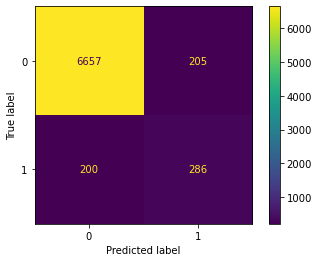

Confusion Matrix results, Dataset:  Validation


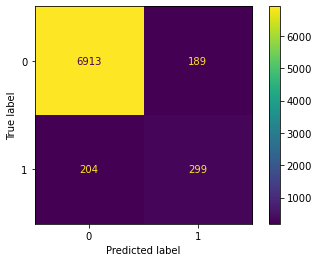

In [86]:
# balanced default data
make_confusion(rf_model, X_test_def_os, y_test_def_os, 'Test')
make_confusion(rf_model, X_val_def_os, y_val_def_os, 'Validation')

In [52]:
# balanced "future step" data
evaluate(rf_model_fs, X_val_fs_os, y_val_fs_os)

# COMPARE TO (with test data):
# Test Accuracy :       0.98950
# Test Precision score: 0.34286
# Test Recall score:    0.21053
# Test F1 score:        0.26087
# Test ROC_AUC score:   0.82358
# Test PRC_AUC score:   0.16752
# Test Confusion Matrix:
# [[6398   23]
#  [  45   12]]

Predict time to compute: 0.513 seconds
Test predict probas time to compute: 0.501 seconds
PR AUC: 0.193
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.99031
Test Precision score: 0.40625
Test Recall score:    0.22034
Test F1 score:        0.28571
Test ROC_AUC score:   0.84707
Test PRC_AUC score:   0.19273
Test Confusion Matrix:
[[6627   19]
 [  46   13]]


Confusion Matrix results, Dataset:  Test


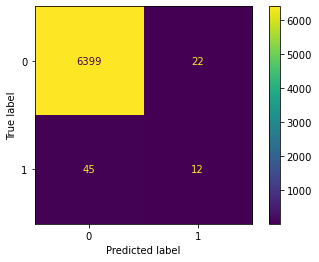

Confusion Matrix results, Dataset:  Validation


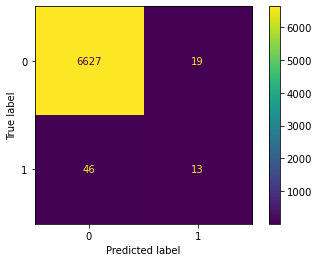

In [87]:
# balanced "future step" data
make_confusion(rf_model_fs, X_test_fs_os, y_test_fs_os, 'Test')
make_confusion(rf_model_fs, X_val_fs_os, y_val_fs_os, 'Validation')

In [24]:
# XG BOOST VALIDATION

# balanced default data
evaluate(xg_model, X_val_def_os, y_val_def_os)

# COMPARE TO (with test data):
# Test Accuracy :       0.94624
# Test Precision score: 0.59267
# Test Recall score:    0.59877
# Test F1 score:        0.59570
# Test ROC_AUC score:   0.93694
# Test PRC_AUC score:   0.60943
# Test Confusion Matrix:
# [[6662  200]
#  [ 195  291]]

Predict time to compute: 0.112 seconds
Test predict probas time to compute: 0.111 seconds
PR AUC: 0.238
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.93202
Test Precision score: 0.43519
Test Recall score:    0.09344
Test F1 score:        0.15385
Test ROC_AUC score:   0.73729
Test PRC_AUC score:   0.23819
Test Confusion Matrix:
[[7041   61]
 [ 456   47]]


Confusion Matrix results, Dataset:  Test


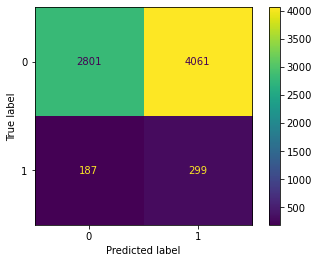

Confusion Matrix results, Dataset:  Validation


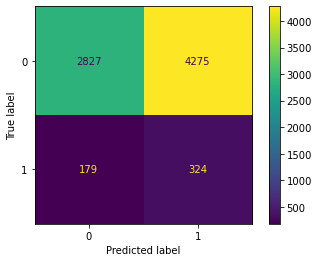

In [116]:
# balanced default data
make_confusion(xg_model, X_test_def_os, y_test_def_os, 'Test')
make_confusion(xg_model, X_val_def_os, y_val_def_os, 'Validation')

In [118]:
# balanced "future step" data
evaluate(xg_model_fs, X_val_fs_os, y_val_fs_os)

# COMPARE TO (with test data):
# Test Accuracy :       0.98889
# Test Precision score: 0.25806
# Test Recall score:    0.14035
# Test F1 score:        0.18182
# Test ROC_AUC score:   0.73223
# Test PRC_AUC score:   0.13621
# Test Confusion Matrix:
# [[6398   23]
#  [  49    8]]

Predict time to compute: 0.018 seconds
Test predict probas time to compute: 0.014 seconds
PR AUC: 0.345
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.39448
Test Precision score: 0.00980
Test Recall score:    0.67797
Test F1 score:        0.01932
Test ROC_AUC score:   0.53497
Test PRC_AUC score:   0.34530
Test Confusion Matrix:
[[2605 4041]
 [  19   40]]


Confusion Matrix results, Dataset:  Test


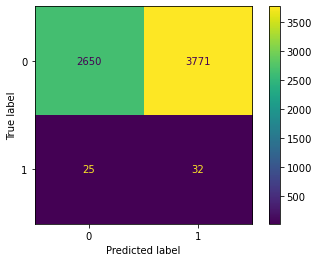

Confusion Matrix results, Dataset:  Validation


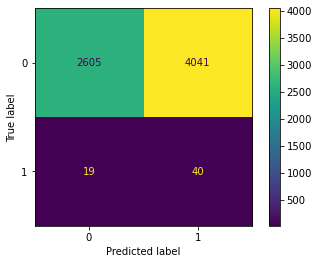

In [119]:
# balanced "future step" data
make_confusion(xg_model_fs, X_test_fs_os, y_test_fs_os, 'Test')
make_confusion(xg_model_fs, X_val_fs_os, y_val_fs_os, 'Validation')

In [67]:
# KNN VALIDATION

# balanced default data
evaluate(kn_model, X_val_def_os, y_val_def_os)

# COMPARE TO (with test data):
# Test Accuracy :       0.92624
# Test Precision score: 0.45808
# Test Recall score:    0.62963
# Test F1 score:        0.53033
# Test ROC_AUC score:   0.87726
# Test PRC_AUC score:   0.56873
# Test Confusion Matrix:
# [[6500  362]
#  [ 180  306]]

Predict time to compute: 47.375 seconds
Test predict probas time to compute: 47.035 seconds
PR AUC: 0.532
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.92952
Test Precision score: 0.47385
Test Recall score:    0.59443
Test F1 score:        0.52734
Test ROC_AUC score:   0.91228
Test PRC_AUC score:   0.53248
Test Confusion Matrix:
[[6770  332]
 [ 204  299]]


Confusion Matrix results, Dataset:  Test


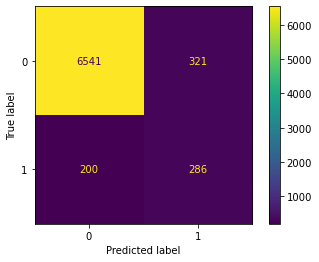

Confusion Matrix results, Dataset:  Validation


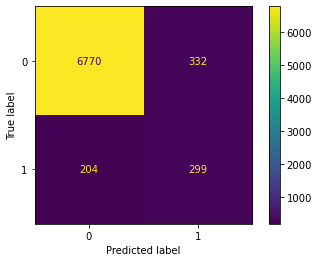

In [90]:
# balanced default data
make_confusion(kn_model, X_test_def_os, y_test_def_os, 'Test')
make_confusion(kn_model, X_val_def_os, y_val_def_os, 'Validation')

In [68]:
# balanced "future step" data
evaluate(kn_model_fs, X_val_fs_os, y_val_fs_os)

# COMPARE TO (with test data):
# Test Accuracy :       0.95230
# Test Precision score: 0.10870
# Test Recall score:    0.61404
# Test F1 score:        0.18470
# Test ROC_AUC score:   0.90932
# Test PRC_AUC score:   0.30179
# Test Confusion Matrix:
# [[6134  287]
#  [  22   35]]

Predict time to compute: 42.087 seconds
Test predict probas time to compute: 42.645 seconds
PR AUC: 0.313
--------------------------------------------------
--------------------------------------------------
Test Accuracy :       0.94825
Test Precision score: 0.10870
Test Recall score:    0.67797
Test F1 score:        0.18735
Test ROC_AUC score:   0.92136
Test PRC_AUC score:   0.31345
Test Confusion Matrix:
[[6318  328]
 [  19   40]]


Confusion Matrix results, Dataset:  Test


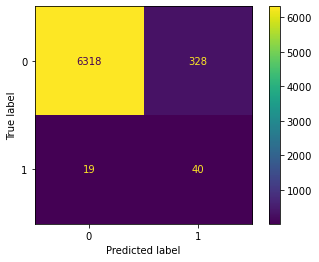

Confusion Matrix results, Dataset:  Validation


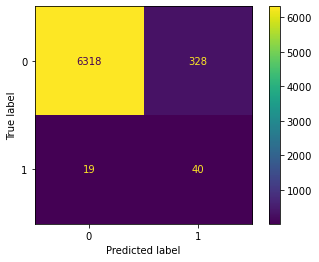

In [91]:
# balanced "future step" data
make_confusion(kn_model_fs, X_val_fs_os, y_val_fs_os, 'Test')
make_confusion(kn_model_fs, X_val_fs_os, y_val_fs_os, 'Validation')

# Interpretable Models - Random Forest

In [109]:
# make the grid search and optimized model data names a little easier to write
# only using basic data for grid search, since oversampling data results get skewed

# X_g, y_g

# # Future step:
# X_train_fs, X_test_fs, X_val_fs, y_train_fs, y_test_fs, y_val_fs

# # General:
# X_train, X_test, X_val, y_train, y_test, y_val

# Random Forest
get_influence(rf_model[0], X_train)

,Variable,Importance
19,dd_age_years,0.170162
38,dd_combined_main_breed,0.080512
23,dd_weight_range,0.064863
14,db_barks_frequency,0.035138
6,db_fear_level_loud_noises,0.033297
16,db_playful_frequency,0.032817
0,hs_general_health,0.032665
13,db_training_obeys_stay_command_frequency,0.031262
34,mp_dental_brushing_frequency,0.030583
10,db_attention_seeking_follows_humans_frequency,0.028884


Elapsed time to compute the importances: 0.141 seconds


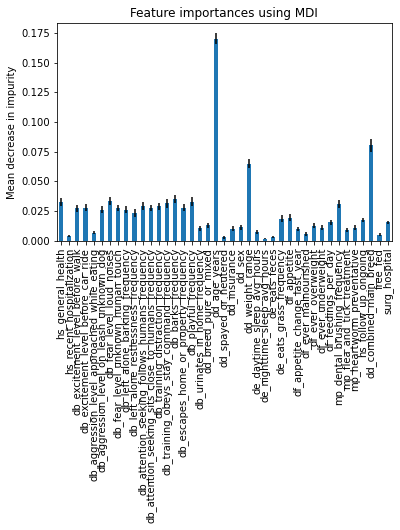

In [110]:
# source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
feature_names_txt = X_train.columns.values.tolist()

start_time = time.time()
# feature_importances_ - computed as the mean and standard deviation of 
#  accumulation of the impurity decrease within each tree
importances = rf_model[0].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model[0].estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=feature_names_txt)


# plot the impurity-based importance
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# blue bars are the feature importances of the forest, along with their inter-trees variability represented by the error bars

In [112]:
start_time = time.time()
result = permutation_importance(
    rf_model[0], X_test, y_test, n_repeats=10, random_state=0, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names_txt)

Elapsed time to compute the importances: 176.207 seconds


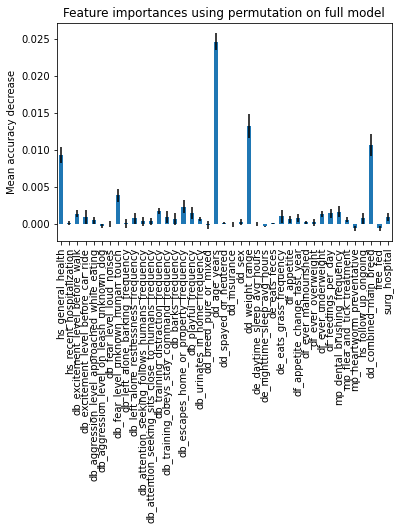

In [113]:
forest_importances = pd.Series(result.importances_mean, index=feature_names_txt)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

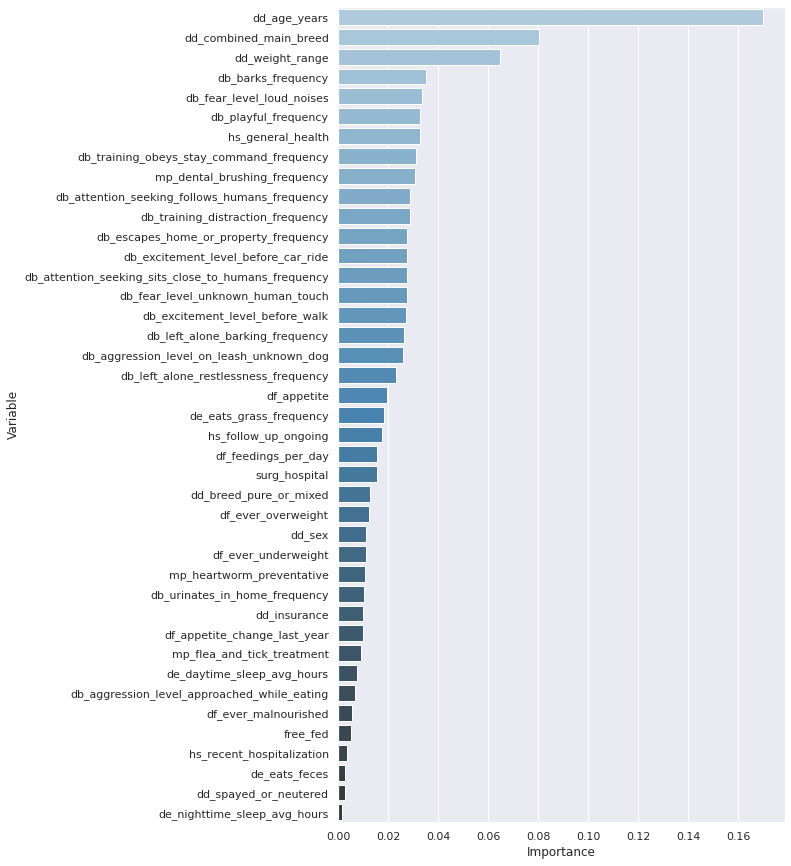

In [122]:
data_rf = get_influence(rf_model[0], X_train)
sns.set(rc = {'figure.figsize':(8,15)})
ax = sns.barplot(x="Importance", y="Variable", data=data_rf, palette="Blues_d")

In [123]:
# Compare to XGBoost
data_xg = get_influence(xg_model[0], X_train)
data_xg

,Variable,Importance
21,dd_insurance,0.190790
17,db_urinates_in_home_frequency,0.172704
7,db_fear_level_unknown_human_touch,0.159639
29,df_appetite_change_last_year,0.075761
40,surg_hospital,0.068092
4,db_aggression_level_approached_while_eating,0.036431
8,db_left_alone_barking_frequency,0.021206
30,df_ever_malnourished,0.017853
0,hs_general_health,0.017838
20,dd_spayed_or_neutered,0.016928


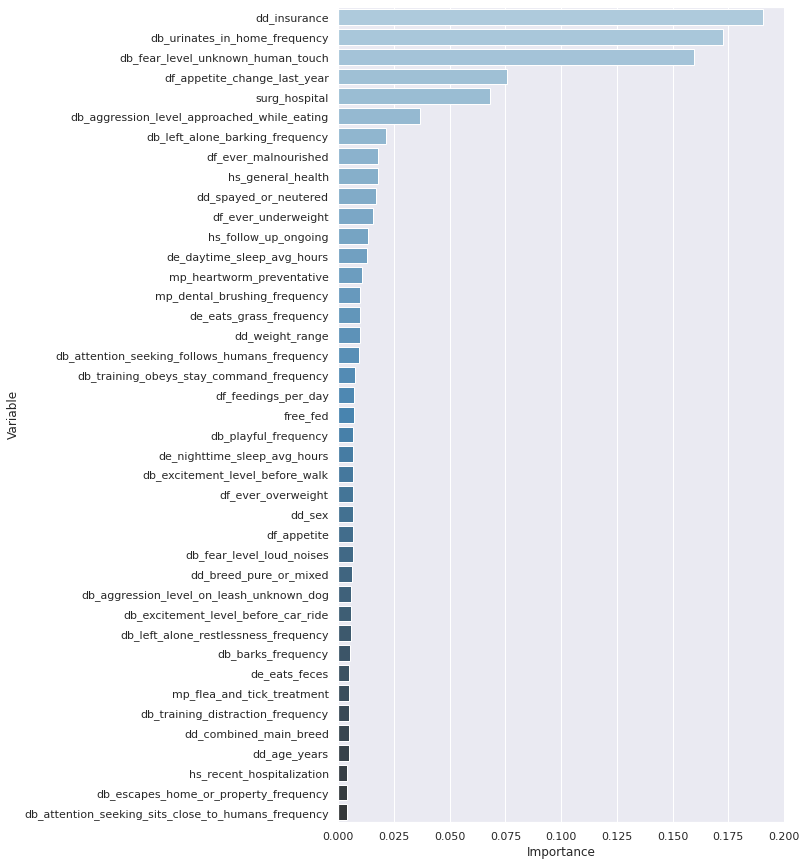

In [124]:
sns.set(rc = {'figure.figsize':(8,15)})
ax = sns.barplot(x="Importance", y="Variable", data=data_xg, palette="Blues_d")